<a href="https://colab.research.google.com/github/MaximNetolog/index.html-/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_%D0%9F%D0%BE%D0%BB%D0%B5%D1%82%D0%B0%D0%B5%D0%B2_%D0%9C%D0%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дипломная работа по теме:

# “Анализ продаж британской сетевой e-commerce TATA (поиск инсайтов, составление рекомендаций стейкхолдерам, построение предиктивной модели объёмов продаж)”

# Профессия “Аналитик данных”, DAU-67                                          
# Полетаев Максим Васильевич

# Загрузки

In [103]:
import numpy as np # для обработки числвых значений
import pandas as pd # для обработки данных
from datetime import datetime, timedelta # для обработки дат
import re # для обработки регулярных выражений
import matplotlib.pyplot as plt # для обработки визуализации данных
import seaborn as sns # для визуализации статистических данных
from statsmodels.tsa.stattools import adfuller # для обработки
from sklearn.model_selection import train_test_split # для обработки
from sklearn.linear_model import LinearRegression # для обработки
from sklearn.metrics import mean_squared_error, root_mean_squared_error # для предсказания и вычисления mse, rmse
import statsmodels.api as sm # для статистики
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Функции

## Функция визуализации объема продаж
**Параметры**:
 - sales_grouped (DataFrame) - датафрейм с объемом продаж по месяцам

In [104]:
def plot_sales(sales_grouped):

    plt.figure(figsize=(15, 5))
    plt.plot(range(len(sales_grouped['month_year'])), sales_grouped['sales_volume_m'], marker='o', color='blue', label='Объём продаж')
    plt.bar(range(len(sales_grouped['month_year'])), sales_grouped['sales_volume_m'], color='gray', alpha=0.3)
    plt.xticks(range(len(sales_grouped['month_year'])), sales_grouped['month_year'].dt.strftime('%m-%Y'))

    plt.style.use('default')    # Устанавливаем стиль "белого" фона с серыми границами
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = '#cccccc'

    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.ylabel('Объём продаж в миллионах ФС "£m"')
    plt.xlabel('за месяц')
    plt.title('Объём продаж за каждый месяц')
    plt.grid(False)

## Функция для визуализации предсказанных значений
**Параметры**:
 - y_pred_series (pandas.Series) - серия предсказанных значений

In [105]:
def plot_y_pred(y_pred_series, color):

    plt.plot(y_pred_series.index, y_pred_series, color = color, linewidth=2, label='Предсказанные значения')    # Отображение
    plt.scatter(y_pred_series.index, y_pred_series, color = color)  # Отображаем точки предсказаний

    plt.style.use('default')    # Устанавливаем стиль "белого" фона с серыми границами
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = '#cccccc'

    plt.legend()
    plt.grid(False)

## Функция для визуализации метрик

**Параметры:**

 - x_values (numpy.ndarray) - Массив значений по оси X

 - intercept_pvalue (float) - p-value для оценки значимости свободного члена регрессии.

 - slope_pvalue (float) - p-value для оценки значимости коэффициента регрессии.

 - rmse (float) - Значение RMSE (Root Mean Squared Error).

Из-за изменения диапазона x_values, необходимо заново рассчитывать линию регрессии и диапазон для RMSE

In [106]:
def plot_metrics(x_values, intercept_pvalue, slope_pvalue, rmse):

    regression_line = intercept + slope * x_values + k # Линия регрессии
    upper_bound = regression_line + rmse # Массив значений верхней границы диапазона RMSE.
    lower_bound = regression_line - rmse # Массив значений нижней границы диапазона RMSE.
    plt.text(0.5, 0.9, f'P-value (Intercept): {intercept_pvalue:.4f}', transform=plt.gca().transAxes) # Отображение p-value для пересечения
    plt.text(0.5, 0.85, f'P-value (Slope): {slope_pvalue:.4f}', transform=plt.gca().transAxes) # Отображение p-value для наклона
    plt.text(0.5, 0.8, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes) # Отображение RMSE
    # Отображение линии регрессии и границ RMSE
    plt.plot(x_values, regression_line, color='green', linewidth=2, label='Линия регрессии')
    plt.fill_between(x_values, lower_bound, upper_bound, color='orange', alpha=0.3, label='Диапазон RMSE')
    plt.grid(False)

# Функция оценки модели линейной регрессии
Оценивает модель линейной регрессии, вычисляя и сравнивая RMSE тренировочных и тестовых данных, для определения, обобщает ли модель свои знания и переобучена ли модель.

**Параметры:**

 - rmse_train (float) - значение RMSE для тренировочных данных.
 - rmse_test (float) - значение RMSE для тестовых данных.
 - threshold_percentage (необязательный, по умолчанию 0.05) (float) - пороговое значение для относительной разницы между RMSE тренировочных и тестовых данных. Если разница меньше этого порога, модель считается обобщающей.
 - overfitting_threshold (необязательный, по умолчанию 1.05) (float) - пороговое значение для отношения RMSE тренировочных и тестовых данных. Если RMSE тренировочных данных меньше или равно RMSE тестовых данных, умноженных на этот порог, модель считается не переобученной.

 - threshold_percentage (float) - порог для оценки обобщающей способности модели (по умолчанию 0.05, т.е. 5%)

 - overfitting_threshold (float) - порог для определения переобучения (по умолчанию 1.05, т.е. 5%)
    
**Возвращает:** результат сравнения RMSE для тренировочных и тестовых данных

In [107]:
def evaluate_linear_regression_model(rmse_train, rmse_test, threshold_percentage=0.05, overfitting_threshold=1.05):

    print("RMSE (тренировочные данные):", round(rmse_train, 2))
    print("RMSE (тестовые данные):", round(rmse_test, 2))

    # Выводим результаты сравнения RMSE для тренировочных и тестовых данных
    if abs(round(rmse_train, 2) - round(rmse_test, 2)) / rmse_train < threshold_percentage:
        print("Модель, вероятно, хорошо обобщает свои знания")
    else:
        print("Модель, возможно, не в полной мере обобщает свои знания")

    if rmse_train <= rmse_test * overfitting_threshold:
        print("Модель, возможно, переобучена")
    else:
        print("Модель, скорее всего, не переобучена")

# Загрузка данных о работе e-commerce TATA. Файл с данными взят с сайта [Kaggle](https://www.kaggle.com/datasets/ishanshrivastava28/tata-online-retail-dataset "TATA: набор данных по интернет-торговле")

In [108]:
df = pd.read_csv('Online Retail Data Set.csv', encoding = 'ISO-8859-1') # читаем файл Online Retail Data Set.csv с помощью pandas
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [109]:
df.info() # Посмотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Краткое описание данных

Файл с данными "Online Retail Data Set", объёмом 43.9 МБ в формате csv. Файл содержат 8 колонок, каждая колонка имеет заголовок:
* **InvoiceNo** - Номер счета-фактуры имеет тип object.
Счета имеют четыре типа:

 *Корректирующий счёт* - Колонка "InvoiceNo" содержит префикс "А"

 *Счёт возврата товара* - Колонка "InvoiceNo" содержит префикс "C" , обозначающий "Credit" (кредитовую нота)

 *Счета списания* - Колонка "InvoiceNo" состоит только цифры (без префикса), , при этом значение цены "UnitPrice" = 0

 *Покупки* - Колонка "InvoiceNo" состоит только цифры (без префикса), при этом цена "UnitPrice" > 0

* **StockCode** - Код товара
* **Description** - Описание товара. Может содержать пустые значения только для счетов-фактуры с продажами (номер счёта-фактуры без префикса "С"). Вероятно, система не даёт создать счёт-фактуру на возврат без заполнения поля "описание". Все пропуски в колонке "описане" соотносятся с нулевым значением цены и только к Великобритании.
* **Quantity** - Количество товара. Может содержить не только положительные, но и отрицательные значения, когда товар был возвращен, и счет-фактура с префиксом "C" служит подтверждением возврата.
* **InvoiceDate** - Дата и время создания счёта имеет тип object, т.к. представлена в UK-формате (Британском стандарте написания даты)
* **UnitPrice** - Цена за единицу товара. Необходимо учитывать, что все цены указаны в национальной валюте Великобритании фунт стерлингов (GBP). Может содержать нулевые значения в счетах-фактуры созданных для списаний и подарков.
* **CustomerID** - Идентификатор покупателя
* **Country** - Страна покупателя

**Для более полного отражения в движении денежных средств, нами создана колонка "transaction_amount". Она рассчитывается как перемножение количества товара на стоимость единицы товара.**

In [110]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


# Справочная информация

При анализе предоставленных данных, необходимо учитывать:
1. Дата и время создания счёта представлена в UK-формате (Британском стандарте написания даты)
2. Все цены указаны в национальной валюте Великобритании фунт стерлингов (GBP).


# Проверка и подготовка данных

1. Работа с дубликатами
2. Заменим все пропуски 'CustomerID' на 0
3. Добавим колонку "transaction_amount"
4. Отфильтруем счета возвратов
5. Отфильтруем счета списаний
6. Проведём проверку колонки на формат отображения даты и времени
7. Исправим типы данных

## Проверка дубликатов
Для обеспечения прозрачности общего анализа данных, проведём проверку дубликатов.

In [111]:
df.duplicated().sum() # проверим дубликаты

5268

In [112]:
duplicated = df[df.duplicated()] # создадим фрейм из дубликатов по всем столбцам
duplicate_counts = duplicated.groupby(duplicated.columns.tolist()).size().reset_index(name='count').sort_values(by='count', ascending=False)
# из фрейма duplicated создадим сводную таблицу по каждому признаку с сортировкой 'count'
duplicate_counts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,count
1596,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,05-06-2011 11:37,2.95,16923.0,United Kingdom,19
1595,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,05-06-2011 11:37,2.95,16923.0,United Kingdom,11
3171,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,26-10-2011 12:46,1.25,14102.0,United Kingdom,7
3115,572344,M,Manual,48,24-10-2011 10:43,1.50,14607.0,United Kingdom,5
470,540524,21756,BATH BUILDING BLOCK WORD,1,09-01-2011 12:53,5.95,16735.0,United Kingdom,5
...,...,...,...,...,...,...,...,...,...
1667,556484,22429,ENAMEL MEASURING JUG CREAM,1,12-06-2011 13:17,4.25,16938.0,United Kingdom,1
1666,556484,22326,ROUND SNACK BOXES SET OF4 WOODLAND,2,12-06-2011 13:17,2.95,16938.0,United Kingdom,1
1665,556484,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,12-06-2011 13:17,4.95,16938.0,United Kingdom,1
1664,556481,23182,TOILET SIGN OCCUPIED OR VACANT,3,12-06-2011 13:00,0.83,16115.0,United Kingdom,1


Заметно, что для некоторых номеров счетов получили несколько комбинаций дубликатов. Рассмотрим для примера InvoiceNo=555524 и посчитаем кол-во дубликатов каждой комбинации для счета 555524

In [113]:
filter_555524 = duplicated[duplicated['InvoiceNo'] == '555524'] # Отфильтруем строки в DataFrame duplicated по значению '555524' в столбце 'счет_фактура'
filter_555524_counts = filter_555524.groupby(filter_555524.columns.tolist()).size().reset_index(name='count').sort_values(by='count', ascending=False)
filter_555524_counts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,count
2,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,05-06-2011 11:37,2.95,16923.0,United Kingdom,19
1,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,05-06-2011 11:37,2.95,16923.0,United Kingdom,11
0,555524,21155,RED RETROSPOT PEG BAG,1,05-06-2011 11:37,2.55,16923.0,United Kingdom,1
3,555524,22776,SWEETHEART CAKESTAND 3 TIER,1,05-06-2011 11:37,9.95,16923.0,United Kingdom,1
4,555524,23170,REGENCY TEA PLATE ROSES,12,05-06-2011 11:37,1.65,16923.0,United Kingdom,1
5,555524,23173,REGENCY TEAPOT ROSES,1,05-06-2011 11:37,9.95,16923.0,United Kingdom,1


В данном случае, мы наблюдаем дубликаты для одного и того же номера счета (InvoiceNo) с разными комбинациями товаров (StockCode и Description).
Дубликаты могут указывать на ошибки в данных. Например, если таблица была собрана из нескольких разных таблиц. Либо, один и тот же товар был случайно добавлен в корзину несколько раз. Либо, технические сбои при заказе товара, например задержка/отсутствие отклика при заказе.
Дубликаты являются ошибками, по этому удалим дубликаты.

In [114]:
df = df.drop_duplicates() # удалим дубликаты
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [115]:
print(df.isna().sum()) # пропуски по колонкам

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


На данный момент нас не интересуют пропуски в расшифровке названия товаров и в идентификаторе покупателя, поэтому трогать их не будем

##Проверка состава колонки 'InvoiceDate'.
Для правильной трактовки даты, проведём разделение строк и получение всех уникальных значений

In [116]:
unique_days_or_month_years = df['InvoiceDate'].str.split('-').str[0].astype(int).unique() # Получаем цифры до первого "-" (день или месяц)
unique_month_years_or_days = df['InvoiceDate'].str.split('-').str[1].astype(int).unique() # Получаем цифры между первым и вторым "-" (месяц или день)
sorted_unique_days_or_month_years = sorted(unique_days_or_month_years) # сортируем уникальные значения
sorted_unique_month_years_or_days = sorted(unique_month_years_or_days)
print("Уникальные значения расположенных до '-'", sorted_unique_days_or_month_years)
print("Уникальные значения между '-'", unique_month_years_or_days)

Уникальные значения расположенных до '-' [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Уникальные значения между '-' [12  1  2  3  4  5  6  7  8  9 10 11]


In [117]:
df_copy = df.copy()
df_copy['InvoiceDate'] = pd.to_datetime(df_copy['InvoiceDate'], format='%d-%m-%Y %H:%M') # преобразуем 'Дата_время' в datetime формат
df_copy['month'] = df_copy['InvoiceDate'].dt.month # Извлекаем месяцы
df_copy['year'] = df_copy['InvoiceDate'].dt.year # Извлекаем года
df_copy['month_year'] = pd.to_datetime(df_copy['InvoiceDate']).dt.to_period('M') # создадим группу с группировкой по месяцу и году
df_copy['transaction_amount'] = df_copy['Quantity'] * df_copy['UnitPrice'] # добавим колонку суммы по каждой сделке по товару
df_copy['transaction_amount'] = df_copy['transaction_amount'].astype('float64') # задаём формат новой колонки для сумм по каждой сделке
df_copy['CustomerID'] = df_copy['CustomerID'].fillna(0).astype('int32')
df_copy['Quantity'] = df_copy['Quantity'].fillna(0).astype('int32')
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536641 non-null  object        
 1   StockCode           536641 non-null  object        
 2   Description         535187 non-null  object        
 3   Quantity            536641 non-null  int32         
 4   InvoiceDate         536641 non-null  datetime64[ns]
 5   UnitPrice           536641 non-null  float64       
 6   CustomerID          536641 non-null  int32         
 7   Country             536641 non-null  object        
 8   month               536641 non-null  int32         
 9   year                536641 non-null  int32         
 10  month_year          536641 non-null  period[M]     
 11  transaction_amount  536641 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(4), object(4), period[M](1)
memory usage: 45.0+ MB


## Проверка состава колонки 'InvoiceNo'

Некоторые значения колонки 'InvoiceNo' содержат префикс C. Проверим наличие других префиксов, для этого найдём все уникальные знаки в ячейках колонки 'InvoiceNo'.

In [118]:
unique_chars = set(''.join(df['InvoiceNo'])) # Получаем все уникальные знаки из колонки InvoiceClass
sorted_unique_chars = sorted(unique_chars) # сортируем уникальные значения
print(list(sorted_unique_chars)) # Преобразуем в отсортированный список

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C']


Выберем только те строки, которое начинаются с числа, но могут содержать буквы "C" и/или "A". Проверим, есть ли комбинации, которые содержат буквы С и А после цифр.

In [119]:
filtered_refund = df[df['InvoiceNo'].str.contains(r'^[0-9]+[AC]*[AC]*$')]
unique_chars = set(''.join(filtered_refund['InvoiceNo'])) # Получаем все уникальные знаки из колонки InvoiceClass
print(list(unique_chars)) # Преобразуем в список

['7', '3', '0', '8', '4', '2', '9', '6', '5', '1']


Таких значений нет

In [120]:
df_contains_a = df_copy.loc[(df_copy['InvoiceNo'].str.contains(r'A'))]
df_contains_a

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,0,United Kingdom,8,2011,2011-08,11062.06
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0,United Kingdom,8,2011,2011-08,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0,United Kingdom,8,2011,2011-08,-11062.06


In [121]:
# выбираем строки, содержащие "C" в колонке "счет_фактура" и составляем список номеров "счет_фактура" с возвратами
df_contains_c = df_copy.loc[df_copy['InvoiceNo'].str.contains('C')]
df_contains_c

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,12,2010,2010-12,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,12,2010,2010-12,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,12,2010,2010-12,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,12,2010,2010-12,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,12,2010,2010-12,-6.96
...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,12,2011,2011-12,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,12,2011,2011-12,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,12,2011,2011-12,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,12,2011,2011-12,-1.25


In [122]:
df_contains_c[df_contains_c['Quantity'] >= 0].count() # Для возвратов, проверим, наличие положительных значений или "0" в "Quantity"

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
month,0
year,0


In [123]:
debit_account = df_copy[df_copy['Quantity'] <= 0]
debit_account.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,month,year,transaction_amount
count,10587.000000,10587,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000
mean,-45.576367,2011-06-24 22:24:14.389345536,42.441206,12561.881269,7.194106,2010.925475,-84.441270
min,-80995.000000,2010-12-01 09:41:00,0.000000,0.000000,1.000000,2010.000000,-168469.600000
25%,-10.000000,2011-03-24 12:25:30,1.060000,12709.000000,4.000000,2011.000000,-15.950000
50%,-2.000000,2011-07-04 15:59:00,2.100000,14410.000000,8.000000,2011.000000,-6.800000
75%,-1.000000,2011-10-06 19:51:30,4.950000,16013.500000,10.000000,2011.000000,-2.100000
max,-1.000000,2011-12-09 11:58:00,38970.000000,18282.000000,12.000000,2011.000000,-0.000000
std,1094.050015,NaN,624.566082,5740.370208,3.506143,0.262636,1910.868663


Все строки содержащим букву "С" в номерах счетов, соответствуют только отрицательные значения в колонке "количество", но цена всегда >= 0. Подтверждаем, что префиксом "C" обозначены "Корректировочные счёта-фактуры" - "Credit" (кредитовую нота). Счета возвратов с префиксом "С" меют отрицательные значения "Quantity" подтверждая, что это возвраты.

In [124]:
sales = df_copy[df_copy['InvoiceNo'].str.contains(r'^\d+$')] # Проверка продаж
sales

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12,2010,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12,2010,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,2010-12,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,12,2011,2011-12,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12,2011,2011-12,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,12,2011,2011-12,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,12,2011,2011-12,16.60


Проверим, что в продажах содержатся только положительные значения в колонке "Quantity" и колонке "UnitPrice"

In [125]:
debit_account = sales.query('Quantity == 0 and UnitPrice == 0') # Посмотрим, счета с нулевым количеством и нулевой ценой
debit_account.count()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
month,0
year,0


In [126]:
debit_account = sales[sales['Quantity'] < 0] # Проверим, наличие отрицательных значений в колонке "Quantity" среди продаж
debit_account

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0


Посмотрим, счета с отрицательным количеством и ненулевой ценой и увидим, что таких счетов нет. Это подтверждает, что счета с 'InvoiceNo' состоящие только из цифр являются счетами покупок или счетами списаний.

In [127]:
debit_account = sales.query('Quantity < 0 and UnitPrice != 0') # Посмотрим, счета с отрицательным количеством и ненулевой ценой
debit_account.count()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
month,0
year,0


## Вывод по проверке номеров счёта в колонке "InvoiceNo"
Таким образом, счета могут обозначаться цифровым кодом или с префиксом. Префиксы могут быть только двух видов "А" - корректировка безнадежных долгов и "С" - возвраты, т.к. все строки с префиксом "С" имеют отрицательные значения "Quantity" подтверждая, что это возвраты.

Счета "InvoiceNo" можно разделить на четыре типа:

 * **Корректирующий счёт** - Колонка "InvoiceNo" содержит префикс "А"

 * **Счёт возврата товара** - Колонка "InvoiceNo" содержит префикс "C"

 * **Счета списания** - Колонка "InvoiceNo" состоит только цифры (без префикса),
, при этом значение цены "UnitPrice" = 0

 * **Покупки** - Колонка "InvoiceNo" состоит только цифры (без префикса), при этом цена "UnitPrice" > 0

In [128]:
df_copy['InvoiceDate'] = pd.to_datetime(df_copy['InvoiceDate'], format='%d-%m-%Y %H:%M') # преобразуем 'Дата_время' в datetime формат
time_period = (df_copy['InvoiceDate'].max() - df_copy['InvoiceDate'].min()).days
print(f"Временной период фрейма между самыми ранними и самыми поздними счетами-фактурами составляет {time_period} дня.")

Временной период фрейма между самыми ранними и самыми поздними счетами-фактурами составляет 373 дня.


In [129]:
df_copy['transaction_amount'].sum() # Сложим все суммы счетов фактуры за 373 дня

9726006.953999998

In [130]:
df_copy['transaction_amount'].sum()/df_copy['Quantity'].sum() # Средний чек по товарам = Годовая выручка/Количество проданных товаров за 374 дня fs

1.8839715614638015

**Годовая выручка по всем сделкам, составляет почти 10 000 000 фунтов стерлингов**

## Проверка обычных продаж с нулевой ценой.

In [131]:
df_0 = sales.query('Quantity > 0 and UnitPrice == 0') # Посмотрим, счета с положительным количеством и нулевой ценой
df_0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,0,United Kingdom,12,2011,2011-12,0.0
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,0,United Kingdom,12,2011,2011-12,0.0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,0,United Kingdom,12,2011,2011-12,0.0
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,0,United Kingdom,12,2011,2011-12,0.0


Найдено 1174 строк с нулевым значением в колонке "цена_за_единицу" и положительным количествами товаров. Это могут быть бесплатные товары или подарки, которые предоставляет наш магазин клиенту в качестве акции или бонуса к основному заказу. Также это может быть сделано для корректного отображения информации по заказу или для учета особых условий сотрудничества с клиентом.

In [132]:
df_0_not_name = df_0[df_0['CustomerID'] != 0] # Посмотрим, счета с ненулевым CustomerID
print("Количество счетов-ПОДАРКОВ с указанным покупателем =", df_0_not_name['CustomerID'].count())
print("из общего клдичества счетов-ПОДАРКОВ", df_0['CustomerID'].count())

Количество счетов-ПОДАРКОВ с указанным покупателем = 40
из общего клдичества счетов-ПОДАРКОВ 1174


In [133]:
# Создадим список уникальных значений по клиентам, которым подарены товары c нулевой "цена_за_единицу" и положительным количествами товаров.
df_0_list = df_0['CustomerID'].unique() # уникальные клиенты, получившие подарки
df_0_list_nam = df_0_list[1:] # и уберём пропуски
df_0_list_nam

array([12647, 16560, 14911, 13081, 15107, 17560, 13239, 13113, 14410,
       12457, 17667, 12415, 16818, 12507, 15581, 14646, 16133, 12748,
       15804, 12446, 18059, 14110, 12437, 12431, 13014, 13985, 15602,
       12603, 12444, 16406, 13256], dtype=int32)

Подарки 40 клиентам корректны, но в остальных случаях отсутствуют данные id_кдиента. Чтобы оценить ущерб, найдём цену по коду товара, необходимо сотавить список кодов товаров в списаниях "codes_of_decommissioned".

In [134]:
df_0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,0,United Kingdom,12,2010,2010-12,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,0,United Kingdom,12,2010,2010-12,0.0


In [135]:
codes_of_my_gift = df_0['StockCode'].unique() # список кодов товаров в списаниях
df_filter_codes_my_gift = df[df['StockCode'].isin(codes_of_my_gift)] # отфильтруем все df по codes_of_decommissioned
df_filter_codes_max = df_filter_codes_my_gift.groupby(['StockCode'])['UnitPrice'].max() # для каждого 'код_товара' найдём максимальное значение 'цена_за_единицу', т.к. это реальная цена сделки
df_filter_codes_max

,UnitPrice
StockCode,
10002,1.660
10080,0.850
15030,0.290
15058A,24.960
15060B,8.470
...,...
PADS,0.001
POST,8142.750
gift_0001_10,8.330


In [136]:
# Заменим нулевые значения в write_off_goods['цена_за_единицу'] на соответствующее ему максимальное значение по ключу df_filter_codes_mean['код_товара']
# из df_filter_codes_mean
%%capture
df_0['UnitPrice'] = df_0['StockCode'].map(df_filter_codes_max) # заменим нулевые значения из write_off_goods по индексу код_товара
df_0['transaction_amount'] = df_0['Quantity'] * df_0['UnitPrice'] # восстановим столбец с суммами

In [137]:
df_0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
622,536414,22139,NaN,56,2010-12-01 11:52:00,11.02,0,United Kingdom,12,2010,2010-12,617.12
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.00,0,United Kingdom,12,2010,2010-12,0.00
1971,536546,22145,NaN,1,2010-12-01 14:33:00,2.10,0,United Kingdom,12,2010,2010-12,2.10
1972,536547,37509,NaN,1,2010-12-01 14:33:00,2.55,0,United Kingdom,12,2010,2010-12,2.55
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.00,0,United Kingdom,12,2010,2010-12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,3.95,0,United Kingdom,12,2011,2011-12,55.30
536981,581234,72817,NaN,27,2011-12-08 10:33:00,4.21,0,United Kingdom,12,2011,2011-12,113.67
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,1.55,0,United Kingdom,12,2011,2011-12,372.00
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,1.45,0,United Kingdom,12,2011,2011-12,435.00


In [138]:
df_POST = df_0[df_0['StockCode'] == 'POST'] # отфильтруем все счета_фактуры по значению 'POST'
df_POST['transaction_amount'].describe() # посмотрим статистику по df_POST

,transaction_amount
count,4.000000e+00
mean,6.819553e+06
std,9.027687e+05
min,6.107062e+06
25%,6.412416e+06
50%,6.514200e+06
75%,6.921338e+06
max,8.142750e+06


Если считать по максимальной сумме почтовых затрат, то более 8 000 000 фунтов стерлингов, выпало из учёта под кодом "POST", но без расшифровки. Эти расходы не сопоставимы с регулярными почтовыми расходами (POSTAGE) и составляет более 80% от показанного оборота 10 000 000 фунтов стерлингов. Проверим цены на почтовые услуги.

In [139]:
df_0_high = df_0[df_0['transaction_amount']>50000] # Оставим значения df_0['transaction_amount'] выше 50 000 ф.с.
df_0_high

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
52262,540699,POST,NaN,1000,2011-01-11 09:32:00,8142.75,0,United Kingdom,1,2011,2011-01,8142750.0
136537,547966,DOT,NaN,1000,2011-03-28 15:49:00,4505.17,0,United Kingdom,3,2011,2011-03,4505170.0
205991,554857,POST,NaN,800,2011-05-27 10:08:00,8142.75,0,United Kingdom,5,2011,2011-05,6514200.0
326552,565556,POST,NaN,750,2011-09-05 12:14:00,8142.75,0,United Kingdom,9,2011,2011-09,6107062.5
453998,575505,POST,NaN,800,2011-11-10 10:29:00,8142.75,0,United Kingdom,11,2011,2011-11,6514200.0


In [140]:
df_0_high['transaction_amount'].sum() # сумма обнулённых расходов в фунтах стерлингов

31783382.5

Наблюдаем аномальные затраты на почту под кодом "POST". Эти расходы не сопоставимы с регулярными почтовыми расходами (POSTAGE) от оборота 10 000 000  фунтов стерлингов в год.
Так-же требуется обьяснение расхода с расшифровкой DOT в размере 4505170.0 фунтов стерлингов.
## Вывод по проверке обычных продаж с нулевой ценой: Общая сумма расходов привышает оборот в три раза

## Проверка счетов продаж с отрицательным количеством.

В целом, заметно увеличение количества оборотов с течением времени.

In [141]:
write_off_goods = sales.query('Quantity < 0 and UnitPrice == 0') # Посмотрим, счета с отрицательным количеством и нулевой ценой
write_off_goods

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,0,United Kingdom,12,2010,2010-12,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,0,United Kingdom,12,2011,2011-12,-0.0


In [142]:
write_off_goods.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,month,year,transaction_amount
count,1336.000000,1336,1336.0,1336.0,1336.000000,1336.000000,1336.0
mean,-154.907934,2011-06-15 11:55:00.314371328,0.0,0.0,6.611527,2010.947605,0.0
min,-9600.000000,2010-12-01 16:50:00,0.0,0.0,1.000000,2010.000000,-0.0
25%,-84.000000,2011-03-30 16:40:45,0.0,0.0,4.000000,2011.000000,-0.0
50%,-30.000000,2011-06-08 11:45:30,0.0,0.0,6.000000,2011.000000,-0.0
75%,-8.000000,2011-09-23 14:41:15,0.0,0.0,10.000000,2011.000000,0.0
max,-1.000000,2011-12-08 15:24:00,0.0,0.0,12.000000,2011.000000,-0.0
std,588.292456,NaN,0.0,0.0,3.384851,0.222906,0.0


## Вывод по проверке счетов обычных продаж с отрицательным количеством
Выяснилось, что не все счета с отрицательным количеством товара, содержат префикс "C", который обозначает кредитную ноту.

Возможные причины, по которым счета-фактуры с отрицательным количеством товара могут не иметь префикса "C":

 - Внутренние корректировки: Отрицательное количество может отражать внутренние корректировки или переоценку запасов, а не фактический возврат покупателем Требуется запросить внутренние процедуры компании, которой принадлежит интернет магазин или запросить разъяснения у бухгалтерского отдела, чтобы понять, как именно должны быть обработаны такие случаи.

 - Ошибки ввода данных, созданными при обучении новых сотрудников или не завершенные сделки: Могут быть ошибки ввода данных, когда отрицательное количество товара введено без соответствующего префикса. Но все счета-фактуры без префика "C" с отрицательным количеством товара имеют цену = 0, т.е. присутствует факт списания количества товара, который должен быть исправлен. Но счетов фактуры с положительным количеством и нулевой ценой нет, т.е. исправлений нет.

 - Специфические операции: Некоторые операции, такие как перемещение товара между складами или отделениями, могут быть отражены как отрицательные количества без создания кредитной ноты. Но мы видим счета-фактуры по цене закупки, что и можно характеризовать как перемещения, а с ценой 0 относятся к списаниям.


In [143]:
name_error = write_off_goods['Description'].unique() # Найдём все уникальные значения в колонке 'описание' для счетов-фактуры со списаниями
name_error

array([nan, '?', 'check', 'damages', 'faulty', 'Dotcom sales',
       'reverse 21/5/10 adjustment', 'mouldy, thrown away.', 'counted',
       'Given away', 'Dotcom', 'label mix up', 'samples/damages',
       'thrown away', 'incorrectly made-thrown away.', 'showroom', 'MIA',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'Thrown away.', 'damages/display',
       'damaged stock', 'broken', 'throw away', 'wrong barcode (22467)',
       'wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell", 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800',
       'MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
       'wrong code', 'adjust', 'crush

Зафиксировано 1336 счета-фактуры с отрицательным количеством, но их цены =0, а в колонке "описание" указаны не названия товаров, а причины их списания:

nan, "?", "проверка", "повреждения", "неисправность", "продажа в интернет-магазине",
"обратная корректировка 21/5/10", "заплесневелый, выброшенный", "подсчитано",
"Отдано", "Интернет-магазин", "перепутаны этикетки", "образцы/повреждения",
"выброшен", "неправильно изготовлен - выброшен.", "демонстрационный зал", "MIA
", "Набор от Доткома", "неправильно продан в виде наборов", "Amazon продавал наборы",
"дотком продавал наборы", "неправильно проданные наборы", "? продается как наборы?',
       "?продается в комплекте?", "Выброшен", "повреждения/дисплей",
"поврежденный товар", "сломан", "выбросить", "неправильный штрих-код (22467)",
"неправильный штрих-код", "проблема со штрих-кодом", "?утерян".,
       "выбросил - не могу продать", "выбросил - не могу продать", "ущерб?",
       "быстрое исправление доткома", "Дотком продан в 6-х экземплярах", "продан в комплекте?",
"взломан", "продан как 22467", "Поврежден",
"тайна! Импортировано только 1800 штук",
"ОШИБКА ПРИ ОПЛАТЕ ТОВАРА ПРОДАВЦОМ ЧАНДЛЕРОМ, STO", "ВОЗМОЖНЫЕ ПОВРЕЖДЕНИЯ ИЛИ УТЕРЯНА?",
"повреждена", "ПОВРЕЖДЕН дисплей", "Отсутствует", "неверный код?",
       "неправильный код", "регулировка", "помятый", "повреждения/демонстрационный зал и т.д.",
"образцы", "повреждения/кредиты от ASOS.",
"При доставке 11.10.2010 не был получен rcvd", "Выброшен - заржавел".,
       "продано доткомом как установленное/6", "мокрое/ржавое", "повреждения/дотком?",
"разбито", "отменить предыдущую настройку",
"неправильно указан C550456, см. 47", "повреждено во влажном состоянии",
"Повреждено водой", "отсутствует", "продано как установленное на dotcom",
"продается в комплекте с dotcom и Amazon", "повреждение водой",
"продается в комплекте с dotcom", "Пятна при печати /выброшены",
"пятна при печати /выброшены", "нашел еще на полке",
"Показать образцы", "смешать с c", "заплесневелый, не пригодный для продажи.",
"неправильно маркирован. 23343 в коробке", "неправильно указан запас", "ebay",
       "неправильно поступили обратно на склад", "Повреждения/образцы",
"Продано как 1 на сайте dotcom", "taig adjust отсутствует на складе",
"перепутан код? 84930", "?отображать?", "продано как 1", "?отсутствует",
       "измельченный ctn", "Измельченный", "регулировка температуры", "??", "тест",
"УПС! корректировка", "Dagamed",
"компьютерный архив данных difference?....se", "Неверный ввод данных на складе.",
"неверный ввод данных на складе.", "неправильно закодирован-23343", "проверка наличия на складе",
"смятые коробки", "ВЛАЖНЫЕ/ЗАПЛЕСНЕВЕЛЫЕ", "не удается найти", "заплесневелый",
"Мокрый поддон - выброшен", "регулировка", "неправильно маркирован 20713".,
       "повторная настройка", "Поломки", "20713", "неправильно закодирован 20713",
"Повреждения", "ЧЕК", "Не подлежит продаже, уничтожен.", "продажи в доткомах",
"поврежден воском", "поврежден водой", "В коробке с ошибочным маркировкой было 85123a",
       "неправильно маркирована коробка 22804", "отсутствует?", "мокрая ржавая", "???потерян",
"продан с неправильным штрих-кодом", "ржавый выброшенный", "ржавый выброшенный",
"дотком", "?? отсутствует", "мокрый поддон", "????отсутствует", "?????отсутствует",
       "затерялся в космосе", "мокрый?", "утерян??', '???', 'мокрый", "мокрые коробки", "
повреждения?", "перепутал", "утерян"], dtype=объект.

*Все счета-фактуры без префика "C" с отрицательным количеством товара имеющие цену = 0, являются списаниями. Зададим вопрос данным: "На какие суммы происходят списания".

Чтобы восстановить цену по коду товара, необходимо сотавить список кодов товаров в списаниях "codes_of_decommissioned".*

In [144]:
codes_of_decommissioned = write_off_goods['StockCode'].unique() # список кодов товаров в списаниях
df_filter_codes = df[df['StockCode'].isin(codes_of_decommissioned)] # отфильтруем все df по codes_of_decommissioned
df_filter_codes_mean = df_filter_codes.groupby(['StockCode'])['UnitPrice'].max() # для каждого 'код_товара' найдём максимальное значение 'цена_за_единицу', т.к. это реальная цена сделки
df_filter_codes

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541874,581585,23084,RABBIT NIGHT LIGHT,12,09-12-2011 12:31,2.08,15804.0,United Kingdom
541875,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,09-12-2011 12:31,1.69,15804.0,United Kingdom
541879,581585,22726,ALARM CLOCK BAKELIKE GREEN,8,09-12-2011 12:31,3.75,15804.0,United Kingdom
541885,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,09-12-2011 12:31,0.85,15804.0,United Kingdom


## В списаниях цена товара = 0. Таким образом, общая сумма списания не может учитываться в расходах. Заменим нулевые значения цены_за_единицу товара на соответствующее ему медианное значение, чтобы увидеть скрытые суммы потерь.

In [145]:
write_off_goods['UnitPrice'] = write_off_goods['StockCode'].map(df_filter_codes_mean) # заменим нулевые значения из write_off_goods по индексу код_товара
write_off_goods['сумма_списания'] = write_off_goods['Quantity'] * write_off_goods['UnitPrice'] # восстановим столбец с суммами
write_off_goods.head()

<ipython-input-145-5db8f278d14a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_off_goods['UnitPrice'] = write_off_goods['StockCode'].map(df_filter_codes_mean) # заменим нулевые значения из write_off_goods по индексу код_товара
<ipython-input-145-5db8f278d14a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_off_goods['сумма_списания'] = write_off_goods['Quantity'] * write_off_goods['UnitPrice'] # восстановим столбец с суммами


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,month_year,transaction_amount,сумма_списания
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,7.95,0,United Kingdom,12,2010,2010-12,-0.0,-79.50
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,7.62,0,United Kingdom,12,2010,2010-12,-0.0,-289.56
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.85,0,United Kingdom,12,2010,2010-12,-0.0,-17.00
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.85,0,United Kingdom,12,2010,2010-12,-0.0,-17.00
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,18.95,0,United Kingdom,12,2010,2010-12,-0.0,-113.70


In [146]:
write_off_goods_groupby = write_off_goods.groupby('StockCode')['сумма_списания'].sum().sort_values(ascending=True).reset_index() # группируем по расшифровке суммой
write_off_goods_groupby_higt = write_off_goods_groupby[write_off_goods_groupby['сумма_списания'] < - 10000] # Оставим списания больше 10 000
write_off_goods_groupby_higt

,StockCode,сумма_списания
0,22502,-64950.00
1,85175,-37616.04
2,21135,-37113.44
3,22618,-33552.76
4,79323W,-32602.50
5,47566B,-28054.00
6,22617,-28054.00
7,85172,-25169.20
8,37370,-22194.88
9,23005,-19200.00


POSSIBLE DAMAGES OR LOST?, 'sold as set on dot com and amazon',
       'mystery! Only ever imported 1800', 'incorrect stock entry.',
       'sold as set/6 by dotcom', 'wrongly marked. 23343 in box',
       'wrongly sold sets', 'wet pallet',
       'incorrectly credited C550456 see 47',
       'reverse previous adjustment', '? sold as sets?', 'damages wax',
       'printing smudges/thrown away', 'mouldy, thrown away.',
       ''wet rusty', 'sold as set on dot com', 'check',
       'mouldy, unsaleable.', 'damages', '?', 'Unsaleable, destroyed.',
       'reverse 21/5/10 adjustment', 'Damaged'

ВОЗМОЖНЫ ПОВРЕЖДЕНИЯ ИЛИ УТЕРЯ?, продается в комплекте в интернет-магазинах и на Amazon,
"тайна! Импортировано всего 1800 штук", "неверный складской номер",
"продано доткомом как комплект/6", "неправильно помечено. 23343 в коробке".,
       "неправильно проданные наборы", "мокрая паллета",
"неправильно указан C550456, см. 47",
"отменена предыдущая корректировка", "? продается как наборы?", "поврежден воск",
"пятна на печати/выброшен", "заплесневелый, выброшен",
"мокрый ржавый", "продается в комплекте с интернет-магазином", "чек",
"заплесневелый, не подлежит продаже.", "повреждения", "?", "Не подлежит продаже, уничтожен".,
       "обратная регулировка 21/5/10", "Поврежден"

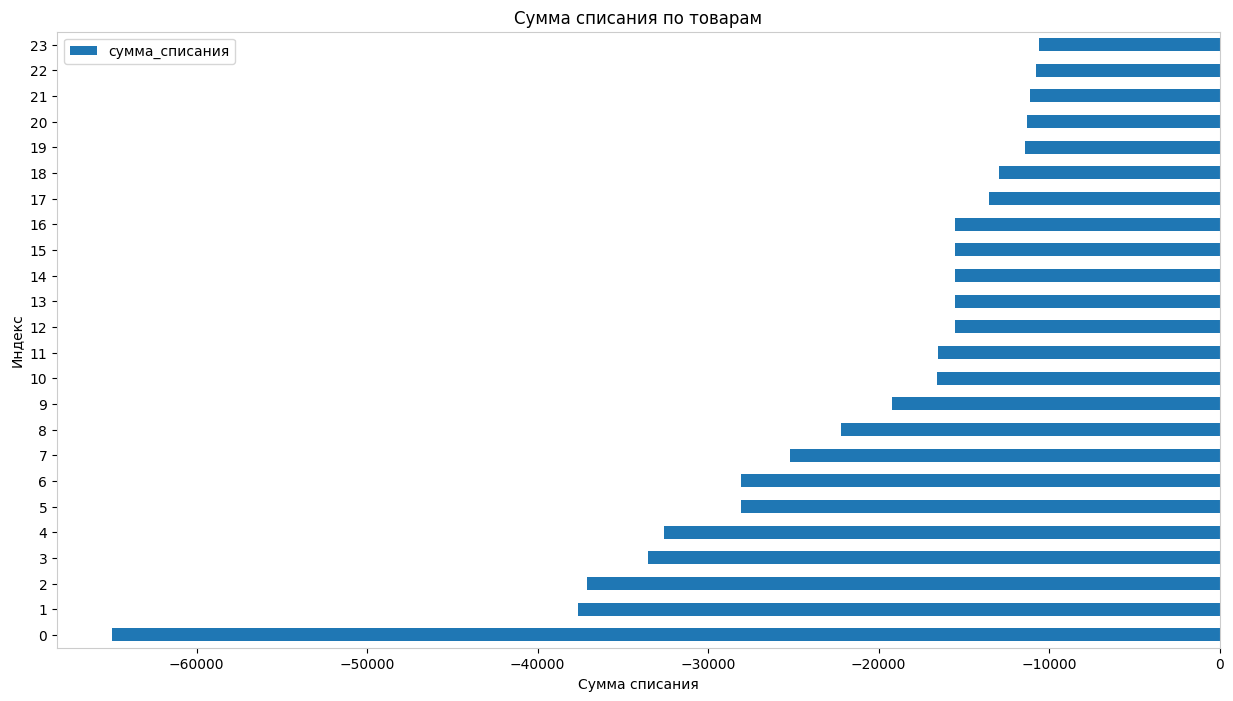

In [147]:
fig, ax = plt.subplots(figsize=(15, 8))
write_off_goods_groupby_higt.plot(kind='barh', ax=ax) # Строим горизонтальную столбчатую диаграмму
ax.set_title('Сумма списания по товарам')
ax.set_xlabel('Сумма списания')
ax.set_ylabel('Индекс')
plt.grid(False)
plt.show()

In [148]:
df_copy_22502 = df_copy[df_copy['StockCode'] == "22502"] # Найдём все движения товара с кодом = 21135
df_copy_22502_max = df_copy_22502.groupby('InvoiceDate')['UnitPrice'].max().reset_index() # Группируем по дате и находим максимальные значения
df_copy_22502_mean = df_copy_22502_max['UnitPrice'].mean() # оставляем среднее значение из всей колонки
df_copy_22502.loc[df_copy_22502['UnitPrice'] == 0, 'UnitPrice'] = df_copy_22502_mean # Заменим нулевые значения на среднее значения
df_copy_22502.loc[:, 'transaction_amount'] = df_copy_22502['Quantity']*df_copy_22502['UnitPrice'] # пересчитаем df_copy_22502['transaction_amount']
df_copy_22502.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,month,year,transaction_amount
count,481.000000,481,481.000000,481.000000,481.000000,481.000000,481.000000
mean,3.887734,2011-04-03 03:37:33.056133120,10.214925,7850.295218,4.927235,2010.889813,106.246928
min,-100.000000,2010-12-01 10:29:00,2.000000,0.000000,1.000000,2010.000000,-1015.652747
25%,1.000000,2011-02-09 13:00:00,5.950000,0.000000,3.000000,2011.000000,8.470000
50%,2.000000,2011-04-06 12:41:00,5.950000,12735.000000,4.000000,2011.000000,16.580000
75%,4.000000,2011-05-17 15:35:00,8.470000,15502.000000,6.000000,2011.000000,23.800000
max,96.000000,2011-09-25 14:33:00,649.500000,18257.000000,12.000000,2011.000000,38970.000000
std,9.937297,NaN,41.400793,7809.532223,3.094502,0.313449,1777.231304


In [149]:
description_22502 = df_copy_22502['Description'].value_counts()
description_22502

,count
Description,
PICNIC BASKET WICKER SMALL,474
PICNIC BASKET WICKER 60 PIECES,2
reverse 21/5/10 adjustment,1


In [150]:
df_copy_85175 = df_copy[df_copy['StockCode'] == "85175"] # Найдём все движения товара с кодом = 85175
df_copy_85175_max = df_copy_85175.groupby('InvoiceDate')['UnitPrice'].max().reset_index() # Группируем по дате и находим максимальные значения
df_copy_85175_mean = df_copy_85175_max['UnitPrice'].mean() # оставляем среднее значение из всей колонки
df_copy_85175.loc[df_copy_85175['UnitPrice'] == 0, 'UnitPrice'] = df_copy_85175_mean # Заменим нулевые значения на среднее значения
df_copy_85175.loc[df_copy_85175['UnitPrice'] == 0, 'UnitPrice'] = df_copy_85175_max['UnitPrice'] # Заменим нулевые значения на среднее значения
df_copy_85175.loc[:, 'transaction_amount'] = df_copy_85175['Quantity']*df_copy_85175['UnitPrice'] # пересчитаем df_copy_22502['transaction_amount']
df_copy_85175.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,month,year,transaction_amount
count,153.000000,153,153.000000,153.000000,153.000000,153.000000,153.000000
mean,16.150327,2011-05-28 18:24:23.137254912,0.968817,13479.130719,6.490196,2010.908497,-2.248827
min,-1200.000000,2010-12-02 10:17:00,0.360000,0.000000,1.000000,2010.000000,-1125.789474
25%,16.000000,2011-02-28 12:14:00,0.420000,13082.000000,3.000000,2011.000000,6.720000
50%,16.000000,2011-05-12 15:17:00,0.420000,14790.000000,6.000000,2011.000000,6.720000
75%,32.000000,2011-09-11 15:44:00,0.420000,16904.000000,10.000000,2011.000000,13.440000
max,256.000000,2011-12-08 14:06:00,13.570000,18250.000000,12.000000,2011.000000,92.160000
std,143.656515,NaN,2.529535,5350.227776,3.656497,0.289270,124.041517


In [151]:
description_85175 = df_copy_85175['Description'].value_counts()
description_85175

,count
Description,
CACTI T-LIGHT CANDLES,147
Amazon sold sets,1
dotcom sold sets,1
wrongly sold sets,1
? sold as sets?,1
check,1


In [152]:
df_copy_21135 = df_copy[df_copy['StockCode'] == "21135"] # Найдём все движения товара с кодом = 21135
df_copy_21135_max = df_copy_21135.groupby('InvoiceDate')['UnitPrice'].max().reset_index() # Группируем по дате и находим максимальные значения
df_copy_21135_mean = df_copy_21135_max['UnitPrice'].mean() # оставляем среднее значение из всей колонки
df_copy_21135.loc[df_copy_21135['UnitPrice'] == 0, 'UnitPrice'] = df_copy_21135_mean # Заменим нулевые значения на среднее значения
df_copy_21135.loc[df_copy_21135['UnitPrice'] == 0, 'UnitPrice'] = df_copy_21135_max['UnitPrice'] # Заменим нулевые значения на максимальные значения
df_copy_21135.loc[:, 'transaction_amount'] = df_copy_21135['Quantity'] * df_copy_21135['UnitPrice'] # пересчитаем 'transaction_amount'
df_copy_21135[['Quantity', 'UnitPrice', 'transaction_amount']].describe()

,Quantity,UnitPrice,transaction_amount
count,188.000000,188.000000,188.000000
mean,5.941489,1.883430,1.976947
std,90.358595,2.438548,133.207364
min,-864.000000,0.200000,-1605.529180
25%,6.750000,1.690000,10.140000
50%,8.000000,1.690000,13.520000
75%,8.000000,1.690000,13.520000
max,576.000000,25.490000,148.720000


In [153]:
description_21135 = df_copy_21135['Description'].value_counts()
description_21135

,count
Description,
VICTORIAN METAL POSTCARD SPRING,185
wet rusty,2
sold as set on dotcom,1


<ipython-input-154-d8c74006617d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_off_goods['InvoiceDate'] = pd.to_datetime(write_off_goods['InvoiceDate']) # преобразуем в datetime
<ipython-input-154-d8c74006617d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_off_goods['week'] = write_off_goods['InvoiceDate'].dt.strftime('%U') # создаем столбец с неделями


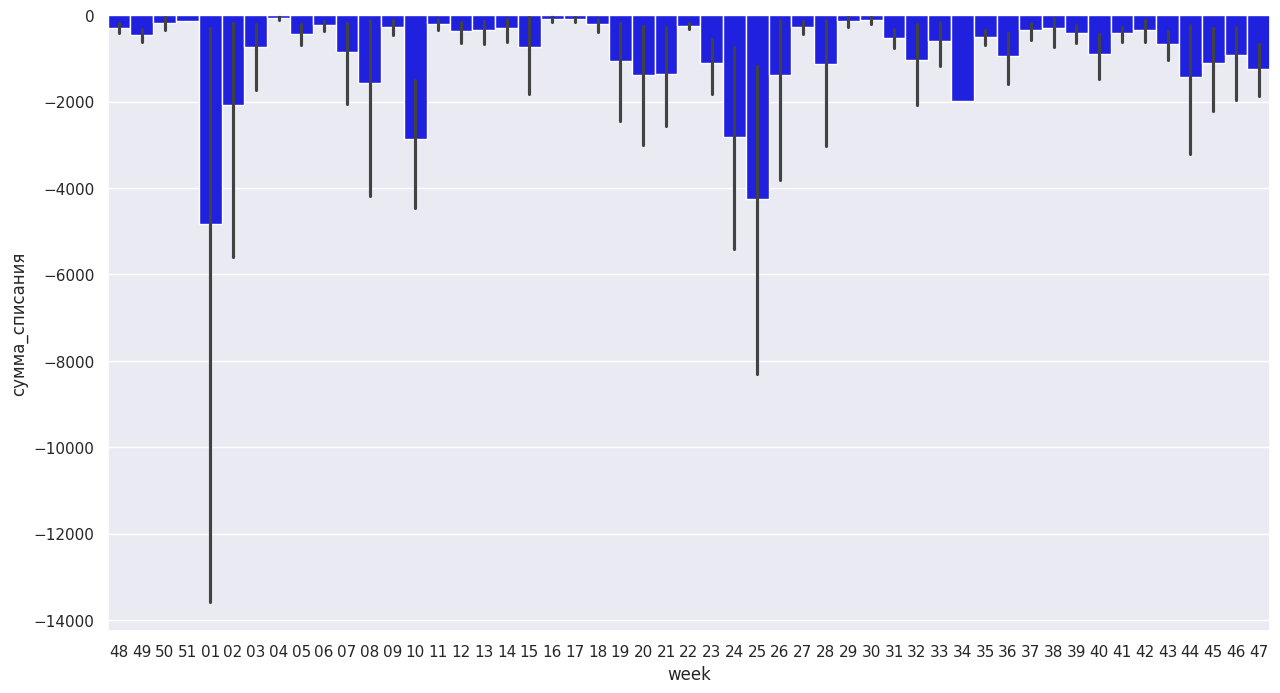

In [154]:
# Построим диаграмму распределения суммы списаний по неделям
write_off_goods['InvoiceDate'] = pd.to_datetime(write_off_goods['InvoiceDate']) # преобразуем в datetime
write_off_goods['week'] = write_off_goods['InvoiceDate'].dt.strftime('%U') # создаем столбец с неделями
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = 'week', y = 'сумма_списания', data = write_off_goods, width=1, color = 'blue')
plt.show()

В причинах списаний очень часто присутствуют фразы: "Набор от Доткома", "неправильно продан в виде наборов", "Amazon продавал наборы", "дотком продавал наборы", "неправильно проданные наборы", "? продается как наборы?', "?продается в комплекте?", "Дотком продан в 6-х экземплярах", "продан в комплекте?", "Отсутствует","продано доткомом как установленное/6" "отсутствует", "нашел еще на полке", "Продано как 1 на сайте dotcom".

Наблюдаем списания как при лишней части товара, так и при недостаче части товара. Вызывает вопрос отсутствие возврата на складской учёт с последующей
отправкой покупателю второй части товара. Для исключения присвоения части товара сотрудниками, необходима проверка фото/видео подтаерждения утилизации.

## Вывод по проверке списаний
Значительную часть списаний связана с комплектностью товара. Директору по  складской логистике, необходимо:
 - продумать меры для снижения подобных ошибок
 - внедрить кодирование причин списания для возможности автоматической  обработки и выявлениея причин системных ошибок

Есть и положительные новости:
 - заметно снижение максимальных объёмов списаний в течении года
 - на фоне увеличения объёмов продаж, нет заметного роста объёмов списаний
 - доля списаний в продажах не вилика

## Проверка счетов возвратов
Рассмотрим по 20 максимальных возвратов и продаж

In [155]:
df_min_contains_c_20 = df_contains_c[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nsmallest(20, 'transaction_amount') # Оставим минимальную сумму возврата
df_min_contains_c_20

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,-168469.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,-77183.60
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098,-38970.00
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,0,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,0,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,0,-16453.71
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,0,-13541.33
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,0,-13541.33
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,0,-13474.79
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:35:00,11586.50,0,-11586.50


In [156]:
sales_max_20 = sales[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nlargest(20, 'transaction_amount') # Оставим строчки с максимальной суммой продаж
sales_max_20

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,0,13541.33
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,8142.75
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,7144.72
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,6539.40
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,6539.40
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646,4992.00
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749,4921.50


Топ две максимальных продажи, совпадают с тремя максимальными возвратами.
Возвраты произошли практически сразу после продажи

In [157]:
df_min_contains_c_20_2 = df_contains_c[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nsmallest(2, 'transaction_amount') # Оставим минимальную сумму возврата
df_min_contains_c_20_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,-168469.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,-77183.6


In [158]:
sales_max_20_2 = sales[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nlargest(2, 'transaction_amount') # Оставим строчки с максимальной суммой продаж
sales_max_20_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.6


Удалим из рассматриваемых фреймов эти 2-е максимальные продажи и посмотрим следующий крупный возврат

In [159]:
df_min_contains_c_20 = df_min_contains_c_20.drop(df_min_contains_c_20.index[:2])
sales_max_20 = sales_max_20.drop(sales_max_20.index[:2])

In [160]:
df_min_contains_c_20_3 = df_min_contains_c_20[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nsmallest(1, 'transaction_amount') # Оставим минимальную сумму возврата
df_min_contains_c_20_3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,-38970.0


In [161]:
sales_max_20_3 = sales_max_20[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nlargest(1, 'transaction_amount') # Оставим строчки с максимальной суммой продаж
sales_max_20_3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,38970.0


Удалим из рассматриваемых фреймов ещё 1-у строку с мальныой продажей

In [162]:
df_min_contains_c_20 = df_min_contains_c_20.drop(df_min_contains_c_20.index[:1])
sales_max_20 = sales_max_20.drop(sales_max_20.index[:1])

Мы видим продажу 60-и комплектов "ПЛЕТЕНЫЕ КОРЗИНЫ ДЛЯ ПИКНИКА (КОМПЛЕКТ ИЗ 60 ШТУК)", а возврат ИНСТРУКЦИИ - 1 шт по цене 38970.0 как 60 комплектов из 60 карзин.

In [163]:
df_min_contains_c_20_4 = df_min_contains_c_20[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nsmallest(5, 'transaction_amount') # Оставим минимальную сумму возврата
df_min_contains_c_20_4

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,0,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,0,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,0,-16453.71
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,0,-13541.33
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,0,-13541.33


In [164]:
sales_max_20_4 = sales_max_20[['InvoiceNo',	'StockCode', 'Description',	'Quantity',	'InvoiceDate',	'UnitPrice',	'CustomerID',	'transaction_amount']].nlargest(1, 'transaction_amount') # Оставим строчки с максимальной суммой продаж
sales_max_20_4

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,transaction_amount
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,0,13541.33


Теперь мы видим 5 крупных возврата от AMAZON FEE, но только для последнего из них мы видим продажу на AMAZON

In [165]:
sales_code = sales.loc[sales['Description'] == 'AMAZON FEE', 'StockCode'].unique() # Найдём все уникальные значения StockCode для расшифровки AMAZON FEE
sales_code

array(['AMAZONFEE'], dtype=object)

In [166]:
sales_code = sales.loc[sales['StockCode'] == 'AMAZONFEE', 'Description'].unique() # Найдём все уникальные значения Description для покупателя AMAZONFEE
sales_code

array(['AMAZON FEE'], dtype=object)

Заключение:

Для части возвратов, отсутствуют покупки, которые должны были быть в течении 30 30 дней до возврата. Интернет-торговля в Великобритании происходит в соответствии с законодательством ЕС и местными законами. Возврат товаров регулировался Законом о правах потребителей 2015 года. Покупатели имели право вернуть большинство товаров в течение 30 дней с момента получения без объяснения причин, и продавец должен был возвратить полную стоимость товара, включая стоимость доставки.

Можно предположить, что покупка была сделана в другом интернет-магазине сети, а возврат проведён через проверяемый магазин. Возникает вопрос к ведению учёта: почему не прописываются расшифровки наименования товара, причины возврата и код товара для партнёрских торговых площадок. Также вызывает большие вопросы цена возвращаемого товара, которая сопоставима с половиной цены среднего автомобиля!

По причине отсутствия информации о ценообразовании, проаналируем диапазоны изменения цен единиц товара с сортировкой по количеству изменений в колонке 'цена_за_единицу'

In [167]:
# Сделаем сводную таблицу изменения цен на единицу товара с сортировкой по количеству изменений в колонке 'цена_за_единицу'
df_price_std = df[['StockCode', 'UnitPrice']].groupby('StockCode').describe().sort_values(by=('UnitPrice', 'std'), ascending=False)
df_price_std.head(10)

UnitPrice                                                    \
                 count         mean           std        min         25%   
StockCode                                                                  
B                  3.0 -3687.353333  12773.366638 -11062.060 -11062.0600   
AMAZONFEE         34.0  7324.784706   4619.549649      1.000   5233.4650   
M                566.0   378.870866   1780.877526      0.000      1.0000   
CRUK              16.0   495.839375    364.164786      1.600    284.2525   
DOT              710.0   290.495859    355.392120      0.000    131.2700   
POST            1256.0    36.933495    326.109801      0.000     18.0000   
BANK CHARGES      37.0   202.855162    271.788843      0.001     15.0000   
D                 77.0    72.484545    219.271071      0.010     13.8800   
S                 62.0    51.060484     86.198654      2.800      7.9525   
22655             47.0   147.457447     69.970710      0.000    125.0000   

                                              
                    50%        75%       max  
StockCode                                     
B            -11062.060     0.0000  11062.06  
AMAZONFEE      5909.875  8071.6575  17836.46  
M                 8.245   280.0500  38970.00  
CRUK            471.770   668.9775   1100.44  
DOT             184.940   264.4875   4505.17  
POST             18.000    18.0000   8142.75  
BANK CHARGES     82.730   366.2700   1050.15  
D                22.970    57.6000   1867.86  
S                20.025    63.1375    570.00  
22655           125.000   125.0000    295.00

Самые частые изменения цен имеют различные сборы, комиссии, проценты, дисконты, скидки, почтовые расходы: AMAZONFEE, Manual, DOTCOM POSTAGE, CRUK Commission, BANK CHARGES. В отличии от них, мануалы и описаниея (код товара "M" может являтся товаром, но у него так же большое количество разнообразных цен. Необходимо подробное рассмотреть этот товар:

In [168]:
df_M = df[df["StockCode"] == "M"] # Найдём все строки df["код_товара"] в столбец "код_товара" = M
df_M

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,01-12-2010 15:35,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,01-12-2010 15:35,18.95,16274.0,United Kingdom
5684,536865,M,Manual,1,03-12-2010 11:28,2.55,NaN,United Kingdom
6798,536981,M,Manual,2,03-12-2010 14:26,0.85,14723.0,United Kingdom
7976,537077,M,Manual,12,05-12-2010 11:59,0.42,17062.0,United Kingdom
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,06-12-2011 14:23,1.25,17841.0,United Kingdom
533082,C581009,M,Manual,-1,07-12-2011 09:15,125.00,16971.0,United Kingdom
534308,C581145,M,Manual,-1,07-12-2011 13:48,9.95,17490.0,United Kingdom
538321,581405,M,Manual,3,08-12-2011 13:50,0.42,13521.0,United Kingdom


In [169]:
df_M.describe() # Посчитаем статистику продаж и возвратов мануалов.

,Quantity,UnitPrice,CustomerID
count,566.000000,566.000000,460.000000
mean,5.166078,378.870866,15282.450000
std,120.838943,1780.877526,1882.606399
min,-1350.000000,0.000000,12352.000000
25%,-1.000000,1.000000,13263.000000
50%,1.000000,8.245000,15502.000000
75%,1.000000,280.050000,16961.250000
max,1600.000000,38970.000000,18283.000000


При анализе изменения цен за единицу товара можно выявить следующее:

Максимальное значение цены (max) составляет 38970 фунт стерлингов, минимальное (min) 0 фунт стерлингов, а среднее (mean) 379 фунт стерлингов.
Медиана (median) равна 11 фунтов стерлингов, стандартное отклонение (std) — 1781 фунтов стерлингов.

Заметно, что существует выброс максимальной цены

In [170]:
# Сделаем анализ изменения цен единицы товара с сортировкой по количеству изменений в колонке 'цена_за_единицу'
df_M_max = df_M[df_M['UnitPrice'] == 38970]
df_M_max

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,10-06-2011 15:31,38970.0,15098.0,United Kingdom


In [171]:
sales_M = df[df['UnitPrice'] == 38970] # Найдём все значения для цены 38970
sales_M

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,10-06-2011 15:31,38970.0,15098.0,United Kingdom


## Вывод по проверке возвратов

В ТОП группах товаров по возвратам (товары с кодом "М" и описанием "Мануал", а также кодом "AMAZON FEE" и описанием "AMAZONFEE" наблюдаются возвраты по непроданным товарам.
Максимальная сумма возврата составляет 38970 фунтов стерлингов, что эквивалентно 0,4% от общего оборота. Это может означать, что продажи были осуществлены через другой интернет-магазин нашей торговой компании.
Отсутствует прозрачность в процессе формирования корректирующих счетов-фактур для магазинов сети.
Возникают большие вопросы к ценообразованию, так как нет связи данных о продажах между различными магазинами нашей торговой сети.
Необходимо провести тщательную проверку, так как существует вероятность фактов мошенничества.

## Таким образом, ключевыми проблемами, которые необходимо устранить, являются:

Непрозрачность в процессе формирования корректирующих счетов-фактур
Отсутствие единой системы учета продаж между магазинами сети
Необходимость проверки возможных фактов мошенничества

# АНАЛИЗ ПОДГОТОВЛЕННЫХ ДАННЫХ
# Описание применённого подхода к анализу данных


В целом, типы данных корректн, но при полном заполнении, колонка 'id_клиента' могла бы иметь тип int32. После заполнения пропусков в колонке 'id_клиента' тип данных был заменен на int32.

Колонка "счет_фактура" имеет тип object, в связи с корректирующими счетами-фактуры, создаваемыми при возврате товара клиентом в магазин. Нумерация таких счетов-фактуры формируется на основании номера исходного счёта-фактуры по которому проходила продажа. К этому номеру добавляется префикс "C", обозначающий "Credit" (кредитовую нота). Это документ, который выдается покупателю для учета возврата товара. Если в графе "количество товара" указано отрицательное число, это указывает на то, что товар был возвращен, и счет-фактура с префиксом "C" служит подтверждением возврата или предстоящего возврата средств или зачета суммы в счет будущих покупок.

Колонка "количество" содержит не только положительные, но и отрицательные значения. Из 1083 записей:

960 отрицательных записей относятся к корректирующим счетам-фактуры.

123 отрицательных записей относятся к счетам списаний

Колонка "описание" имеет пустые значения только для счетов-фактуры с продажами (номер счёта-фактуры без префикса "С"). Вероятно, система не даёт создать счёт-фактуру на возврат без заполнения поля "описание". Все пропуски в колонке "описане" соотносятся с нулевым значением цены и только к Великобритании. Таким образом, если выбрать любой счет-фактуру с пропуском в колонке "описание", то в колонке "цена" будет 0, а в колонке "страна" United Kingdom. Этот факт выявляет серьёзную уязвимость бухгалтерской системы учёта.

Колонка "цена_за_единицу" содержит нулевые значения в счетах-фактуры созданных для списаний и подарков. Если счёт-фактура содержит положительное количество товаров, то это подарки клиентам (цена за товар = 0). Если счёт-фактура содержит отрицательное количество товаров и при этом цена = 0, то это списание товара. При этом номер счёта-фактуры не содержит префикса "С". Всего за год сделано 134 подарка и 131 списание товаров. Необходимо учесть, что количество списанных товаров, так и количество подаренных товаров в каждом счёте может быть несколько. Т.е. количество счетов со списаниями и подарками всегда меньше или равно количеству товаров в них списанных и подаренных.

Для более полного отражения в движении денежных средств, нами создана колонка "сумма_по_счёту". Она рассчитывается как перемножение количества товара на
стоимость единицы товара.

Серьёзный недостаток предоставленных данных в отсутствии информации по продажам в других интернет-магазинах исследуемой торговой сети. Можно только надеяться, что при возврате, какм-то образом проверяются номера счетов-фактуры, код товара, количество, дата продажи, цена и id_клиента. В противном случае существует пространство для мошеннических схем как со стороны покупателей, так и со стороны работников магазина.

Так-же вызывает тревогу оформление списаний товара и оформление подарков. Отсутствие причины списания в колонке "описание", приводит к дополнительным вопросам.

## Описание бизнес-заказчика, его гипотетических болей и целей развития бизнеса.

Владелец интернет-магазина часто берет на себя функции заказчика. Он может столкнуться с такими задачами по решению проблем: по сокращению числа возвратов товаров, мошенничества со стороны клиентов и работников магазина, снижению потерь клиентов, уменьшению случаев когда покупки не завершаются (товары остаются в корзине). Решение проблем развития бизнеса, увеличению общего числа продаж, повышениюе общей прибыли магазина.

## Рекомендации по модели данных бизнес-заказчика:

Для наглядности, дадим рекомендации на примере возможных скрытых убытков:

1. Возврат по счёту C545847 сделан 2020-03-07. В рассматриваемом магазине счёта 545847 нет, а по законадательству Великобритании, возврат товара осуществляется не позднее 30 суток с момента покупки. Это означает, что продажу сделал другой интернет магазин нашей торговой компании.
  - Рекомендация: предоставить данные по продажам в других магазинах для проверки всех подобных случаев.

2. Выявлено, что максимальная сумма возврата больше максимальной суммы покупки.Счет-фактура с номером 551699 только одна: C551699 - это возврат. Дата её создания 2020-05-03, Manual в количестве 1 шт, цена 6930. Это означает, что покупка сделана в другом магазине нашей сети продаж, а возврат проведён в проверяемом магазине. Самый большой вопрос к цене мануала, по которому сделан возврат, она составляет половину стоимости малолитражного автомобиля!
   - Рекомендация: Требуется проверка не только аномальных списаний, но для этого необходимы данные по всей сети магазинов

3. Самые частые изменения цен имеют различные сборы, комиссии, проценты, дисконты, скидки, почтовые расходы: AMAZONFEE, Manual, DOTCOM POSTAGE, CRUK Commission, BANK CHARGES. В отличии от них, мануалы (код товара "M" и описание "Manual") может являтся товаром, но у него так же большое количество разнообразных цен.
   - Рекомендация: Требуется точная фиксация ценообразования

4. В группе товаров с кодом "М" и описанием "Manual" нет ни одиной пары для счёта-фактуры возврата! Т.е. все возвраты мануалов с других интернет магазинов.
   - Рекомендация: требуется масштабировать проверку возвратов по всем группам товаров.

5. Самое большое списание № 556691 с кодом товара 23005 "КОШЕЛЕК С ПРОЕЗДНЫМИ КАРТАМИ "Я ЛЮБЛЮ ЛОНДОН" проведено 2020-06-14 в середине года, на сумму 5114.48 по причине:"пятна от печати/выброшенные".
  - Рекомендация: желательно проверять аномальные списания

6. По товару 79030G "TUMBLER, NEW ENGLAND" наблюдаем стабильные продажи в течении 5-и месяцев и не одного возврата! Вдруг списание по счёту 554143, с невнятным комментарием "damages". Такой комментарий не обьясняет причину "убытка".
  - Рекомендация: Необходима проверка всех фактов списания!

## Визуализируем распределение объёмов продаж по месяцам для выбора модели анализа.
У нас остались только продажи. График объема продаж от месяца к месяцу может подсказать, какая модель лучше отражает изменения. Подготовим данные для графика в виде сводной таблицы, а для этого:

1. Сгруппируем данные по месяцам, вычисляя объём продаж за каждый месяц.

2. Для компактного представления больших сумм фунтов стерлингов, обозначим "миллионы фунтов стерлингов" английским сокращением "£m".

3. Сделаем выборку необходимого диапазона месяцев.

Визуализируем результаты, с помощью функции "plot_sales".

In [172]:
sales_grouped = (sales.groupby(['month', 'year', 'month_year'])['transaction_amount'].sum() / 1000000).reset_index(name='sales_volume_m') # Суммы сделок по каждому месяцу
sales_grouped = sales_grouped.sort_values(by=['year', 'month']) # сортировка сначала по year, а затем по month
sales_grouped['sales_volume_m'] = sales_grouped['sales_volume_m'].astype('float64')
sales_grouped

,month,year,month_year,sales_volume_m
11,12,2010,2010-12,0.821453
0,1,2011,2011-01,0.689812
1,2,2011,2011-02,0.522546
2,3,2011,2011-03,0.716215
3,4,2011,2011-04,0.536968
4,5,2011,2011-05,0.769297
5,6,2011,2011-06,0.760547
6,7,2011,2011-07,0.718076
7,8,2011,2011-08,0.746779
8,9,2011,2011-09,1.056435


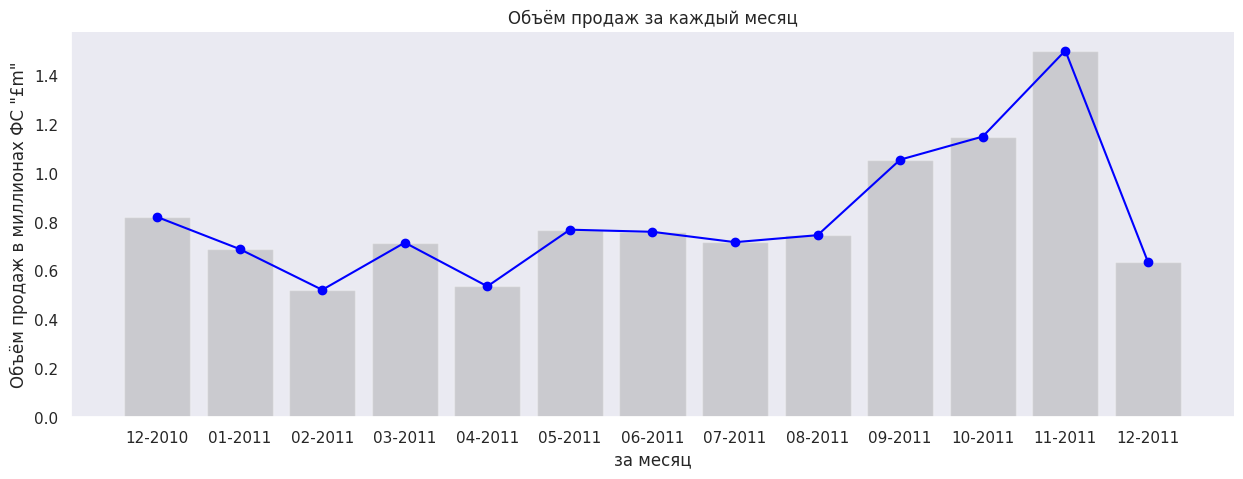

In [173]:
plot_sales(sales_grouped)

## Выводы по визуализации ежемесячных продаж:
1. На графике можно выделить классическую сезонную составляющую в виде спада продаж после декабря 2010 года и роста продаж в конце 2011 года.
2. Май июнь, июль и август имеют стабильные объёмы продаж.
3. Декабрь 2011 стремится к рекордным продажам за год, т.к. только за 9 дней декабря, объёмы продаж превысили минимумы года.

## Дополнительная проверка на отсутствие данных
Факт отсутствия части данных за декабрь 2011 заставляет провести проверки на отсутствие данных в другие дни рассматриваемого периода. Для этого нарисуем еженедельный календарь объёмов продаж с разбивкой по дням недель и посмотрим заполнение таблицы продаж более детально.

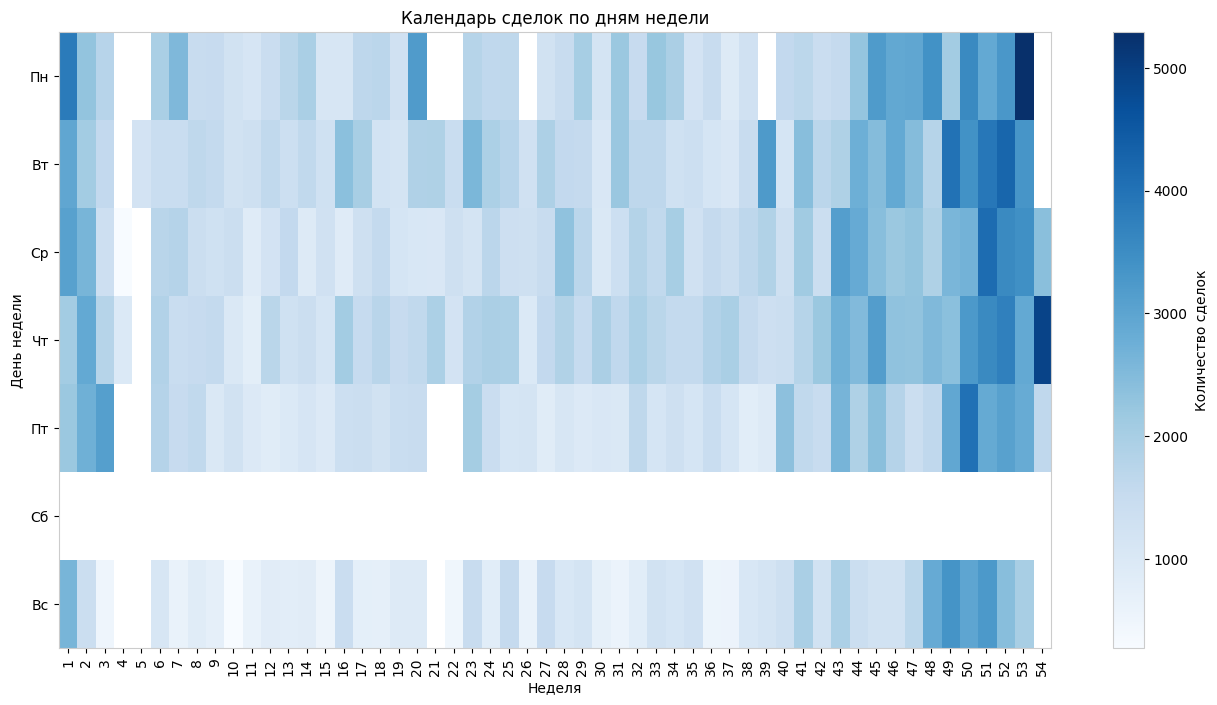

In [174]:
date = df_copy.copy()
date['InvoiceDate'] = pd.to_datetime(date['InvoiceDate'])# Конвертируем столбец 'InvoiceDate' в datetime
date.set_index('InvoiceDate', inplace=True) # Устанавливаем индекс
daily_deals = date.resample('D').size() # Группируем по датам и считаем количество сделок за день
plt.figure(figsize=(16, 8)) # Настраиваем параметры отображения
weeks = (len(daily_deals) + 6) // 7  # количество недель
days_of_week = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
# Заполняем матрицу с количеством сделок по неделям и дням
calendar_matrix = np.zeros((7, weeks))  # 7 дней в неделе, количество недель
for i, (date, value) in enumerate(zip(daily_deals.index, daily_deals.values)):
    week_day = date.weekday()  # Получаем день недели (0 - понедельник, 6 - воскресенье)
    week = i // 7  # Вычисляем номер недели
    column = week if week < weeks else weeks - 1  # Ограничиваем индекс по количеству недель
    calendar_matrix[week_day, column] = value  # Записываем количество сделок
calendar_matrix[calendar_matrix == 0] = np.nan # Заменяем нули на NaN для визуализации (белые клетки)
plt.imshow(calendar_matrix, cmap='Blues', aspect='auto') # Отображаем массив
plt.colorbar(label='Количество сделок')
plt.yticks(np.arange(7), days_of_week)
plt.xticks(np.arange(weeks), range(1, weeks + 1), rotation = 90)
plt.title('Календарь сделок по дням недели')
plt.xlabel('Неделя')
plt.ylabel('День недели')
plt.grid(False)
plt.show()

## Вывод по визуализации календаря продаж по неделям
На календаре продаж наблюдается несколько пустых и "бледных" дней 4-ой и 5-ой недель по счёту. Они совпадают с новогодними и рождественскими праздниками. Но в целом, хорошее заполнение данными. Также отсутствуют продажи по субботам всех недель (выходной день). Остальные, редкие пропуски, возможно праздничные дни или технические перерывы.

## Заключение по визуализации календаря продаж по неделям
Взяв для исследования выборку данных с декабря 2010 г по ноябрь 2011 г, можно предположить, что объёмы продаж линейно увеличиваются от месяца к месяцу.

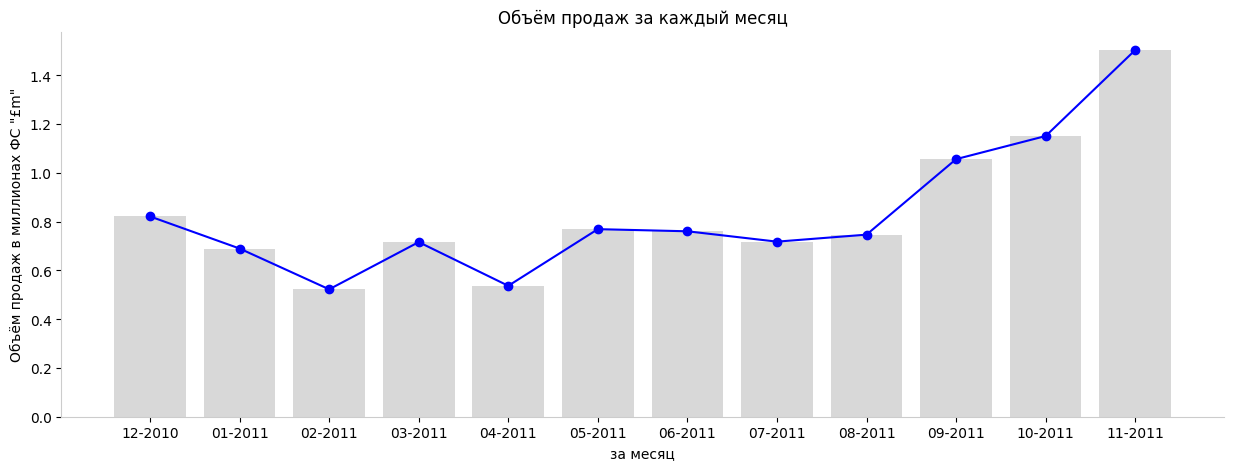

In [175]:
sales_grouped_filtered = sales_grouped[~(sales_grouped['month_year'] == '2011-12-01')]
plot_sales(sales_grouped_filtered) # Вызов функции для визуализации отфильтрованных данных

# Построение модели
Наша задача провести общую оценку финансового состояния компании, проверить предположение ежемесячного линейного прироста объёма продаж с перспективой на будущие три месяца. Применим для этого модель линейной регрессии.
Реализация модели, с отдельными признаками месяца и года, является оптимальной с точки зрения детализации. Обучим модель линейной регрессии на обучающих данных.

|**-**|**Построение модели**|
|:-|:-:|
|*Период данных (выборка)* |*Декабрь 2010 - Ноябрь 2011*|
|*Признаки* |*Месяц, год*|
|*Целевая переменная* |*Общий объем продаж за каждый месяц*|
|*Метод* |*Линейная регрессия*|
|*Результат* |*Прогноз объемов продаж*|
|*Оценка результата* |*Проверка статистической значимости линейной регрессии*|

In [176]:
mlr = sales_grouped_filtered.copy() # Берём копию отфильтрованных данных по 11-2011
mlr['month_year'] = mlr['month_year'].dt.to_timestamp() # Преобразовываем данные из формата period в формат datetime
mlr['month'] = mlr['month_year'].dt.month # Извлекаем месяцы
mlr['year'] = mlr['month_year'].dt.year # Извлекаем года

In [177]:
X_train, X_test, y_train, y_test = train_test_split(mlr[['year', 'month']] , # Определяем сразу 2 признака 'year' и 'month'
                                                    mlr['sales_volume_m'],
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [178]:
model = LinearRegression() # Линейная регрессия
model.fit(X_train, y_train) # Обучение модели линейной регрессии

LinearRegression()

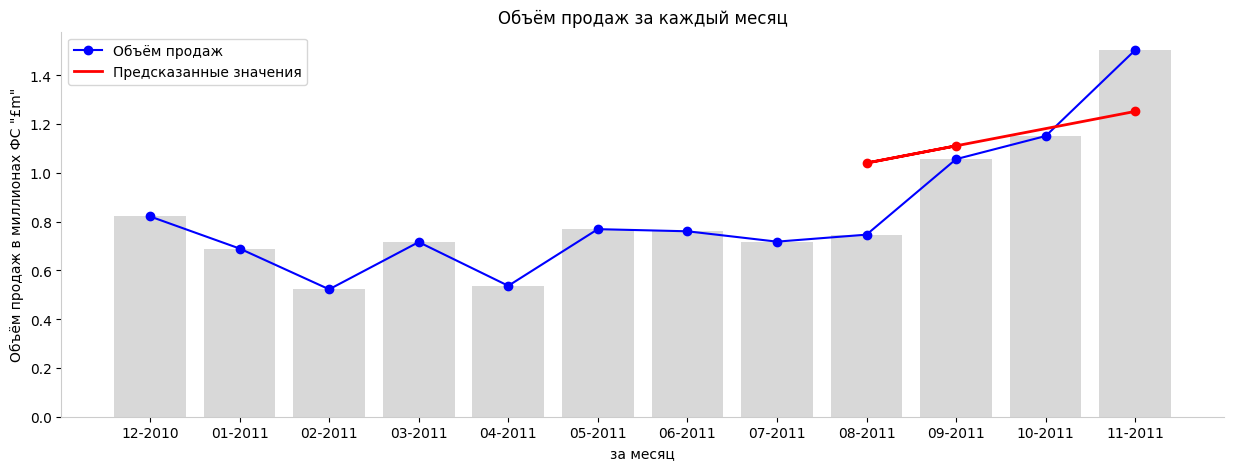

In [179]:
y_pred_test = model.predict(X_test) # Вычислим массив, содержащий предсказанные значения "y" (объема продаж) для каждого образца из тестового набора
y_pred_series = pd.Series(y_pred_test, index=y_test.index) # Вычисление предсказанных значений на основе данных тестовой выборки (X_test) с учетом индексации
plot_sales(mlr) # Вызов функции для визуализации отфильтрованных данных
plot_y_pred(y_pred_series, color='red') # Вызов функции для визуализации добавленной линии предсказаний

# Оценка модели линейной регрессии
Проведём её с помощью коэффициентов модели линейной регрессии и оценки RMSE, P-значений коэффициента пересечения и коэффициента уклона, а также ошибки модели линейной регрессии RMSE

### Сравнение RMSE линейной регрессии для тренировочных и для тестовых данных.
Эта оценка проводится для исключения переобучения (если модель переобучена, она будет очень хорошо работать на тренировочных данных, но плохо - на тестовых).

In [180]:
# Оценка модели линейной регрессии на тестовых данных
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)) # вычисляем корень среднеквадратичной ошибки (RMSE) на тестовой выборке
# Оценка модели линейной регрессии на тренировочных данных
y_pred_train = model.predict(X_train) # предсказание на основе данных обучающей выборки (X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)) # вычисляем корень среднеквадратичной ошибки (RMSE) на обучающей выборке

evaluate_linear_regression_model(rmse_train=rmse_train, rmse_test=rmse_test)

RMSE (тренировочные данные): 0.17
RMSE (тестовые данные): 0.25
Модель, возможно, не в полной мере обобщает свои знания
Модель, возможно, переобучена


###Коэффициенты модели линейной регрессии:
  * P-значение коэффициента пересечения
  * P-значение коэффициента уклона
  
Проверив значимость коэффициентов построенной модели линейной регрессии, мы можем проверить качество модели. Сравним  P-значения коэффициентов уклона и пересечения с уровнем значимости α = 0,01. Если оба значения значимы, то между переменными существует значимая взаимосвязь. В противном случае значимой взаимосвязи нет.

In [181]:
# Коэффициенты модели
X_train_const = sm.add_constant(X_train) # константы независимой переменной тренировочной выборки для признаков 'year' и 'month' статистической модели
model_sm = sm.OLS(y_train, X_train_const).fit() # Соответствие модели (этапу "подгонки" (fitting) линейной регрессионной модели к обучающим данным)
intercept = model_sm.params.iloc[0]  # Пересечение
print("Коэффициенты модели линейной регрессии:")
print("Пересечение:", round(intercept, 4))  # Коэффициент пересечения (свободный член) модели
slope = model_sm.params.iloc[1]  # Коэффициент наклона (коэффициент независимой переменной) модели
print("Наклон:", round(slope, 2))
print("P-значения:")  # P-значения коэффициентов
intercept_pvalue = model_sm.pvalues.iloc[0]  # P-значение пересечения
print("P-значение коэффициента пересечения:", intercept_pvalue)
slope_pvalue = model_sm.pvalues.iloc[1]      # P-значение уклона
print("P-значение коэффициента уклона:", slope_pvalue)

Коэффициенты модели линейной регрессии:
Пересечение: 0.0002
Наклон: 0.07
P-значения:
P-значение коэффициента пересечения: 0.018296905693312403
P-значение коэффициента уклона: 0.014951554557234667


In [182]:
# Генерация x-значений для отображения линии регрессии
x_values = np.arange(len(sales_grouped_filtered['month_year']))

Введём коэффициент коррекции "k", для подгонки модели, чтобы избежать нелинейного изменения признаков "год" и "месяц". Пересечение показывает среднее значение объема продаж, когда год и месяц равны 0, но в нашем случае нулевого месяца нет, поэтому прибавляем к пересечению разницу между значениями января 2012 года (0.475714) и рассчитанным пересечением (0.0002014504636600651)

In [183]:
k = 0.475714 - 0.0002014504636600651

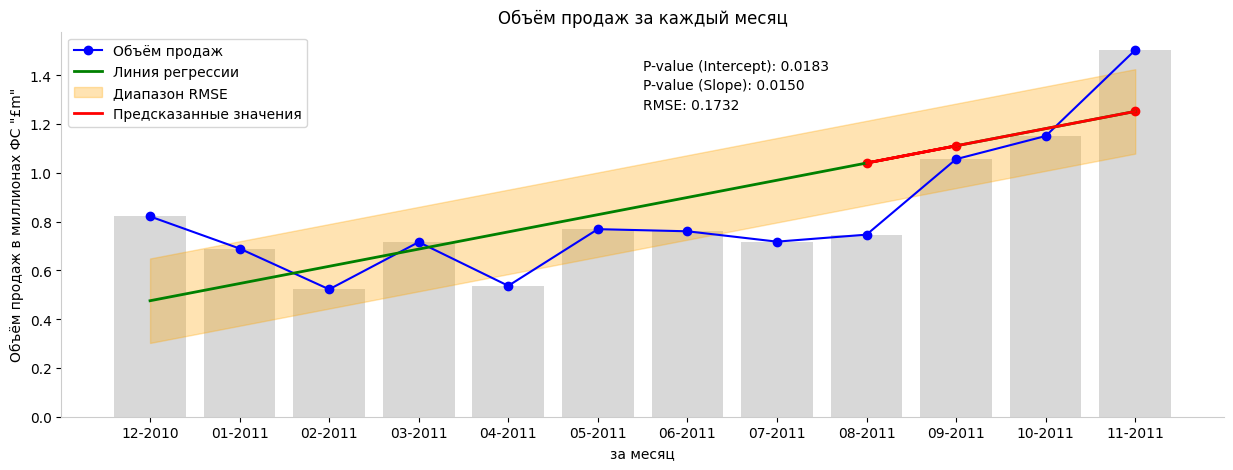

In [184]:
plot_sales(sales_grouped_filtered) # Вызов функции для основного отображения датасета
plot_metrics(x_values, intercept_pvalue, slope_pvalue, rmse = rmse_train) # Вызов функции визуализации метрик
plot_y_pred(y_pred_series, color='red') # Вызов функции для визуализации добавленной линии предсказаний

## Вывод по оценке тренировочных и тестовых данных
Полученная модель, вероятно не обобщает свои знания, т.к. RMSE на тренировочных и тестовых данных значительно отличаются. Модель вероятно переобучена, т.к. RMSE на тренировочных данных намного ниже, чем на тестовых (когда модель слишком хорошо подстраивается под тренировочные данные, но при этом теряет способность обобщать и предсказывать новые примеры).

При уровне значимости α = 0,01 оба коэффициента модели (коэффициент пересечения и коэффициент уклона) не являются статистически значимыми. Можно сделать вывод, что построенная модель линейной регрессии не является статистически значимой и не позволяет с высокой степенью достоверности утверждать, что независимая переменная оказывает значимое влияние на зависимую переменную.

# Метод Ridge Regression
Воспользуемся методом Ridge Regression для регуляризации линейной модели и уменьшения вероятности переобучения. Проведём настройку параметров для Ridge Regression:

In [185]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Примеры значений альфа для регуляризации
ridge_model = Ridge() # Ridge Regression используется для регуляризации линейной модели, что помогает предотвратить переобучение.

Выполним кросс-валидацию для выбора лучшего значения alpha. Воспользуемся помощником GridSearchCV, который позволяет найти оптимальное значение гиперпараметра alpha (alpha контролирует уровень регуляризации)

In [186]:
grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train) # Обучение оптимальной регуляризированной модели линейной регрессии
model = grid_search.best_estimator_ # Получение лучшей регуляризированной модели линейной регрессии
model

Ridge(alpha=100)

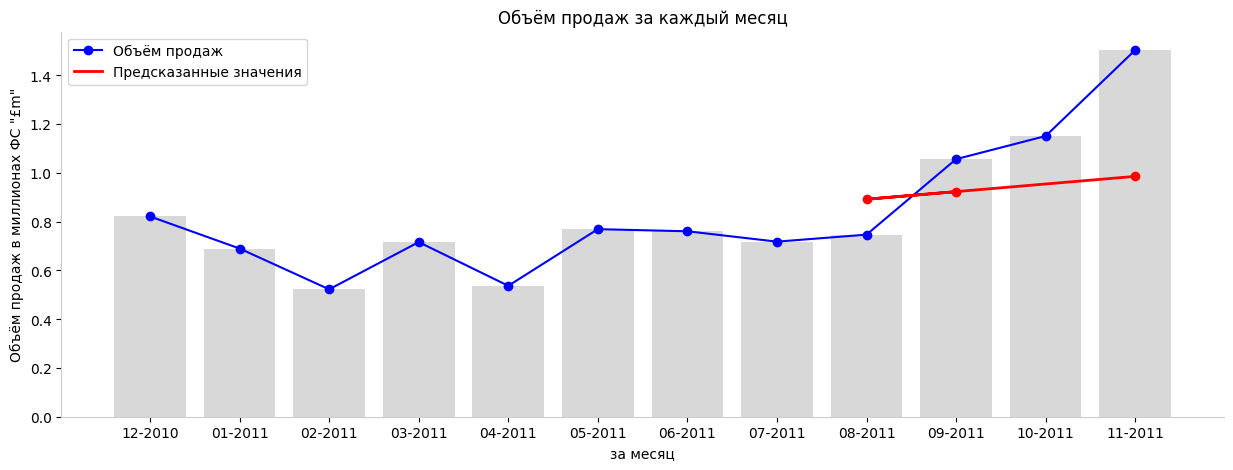

In [187]:
y_pred = model.predict(X_test) # Вычислим массив, содержащий предсказанные значения "y" (объема продаж) для каждого образца из тестового набора
y_pred_series = pd.Series(y_pred, index=y_test.index) # Вычисление предсказанных значений с учетом индексации
plot_sales(sales_grouped_filtered) # Вызов функции для визуализации отфильтрованных данных
plot_y_pred(y_pred_series, color='red') # Вызов функции для визуализации добавленной линии предсказаний

## Оценка регуляризированной модели линейной регрессии
Проведем такую-же оценку для тренировочных и тестовых данных

In [188]:
# Оценка модели линейной регрессии на тренировочных данных
y_pred_train = model.predict(X_train) # предсказание на основе данных обучающей выборки (X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)) # вычисляем корень среднеквадратичной ошибки (RMSE) на обучающей выборке
# Оценка модели линейной регрессии на тестовых данных
y_pred_test = model.predict(X_test) # предсказание на основе данных тестовой выборки (X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)) # вычисляем корень среднеквадратичной ошибки (RMSE) на тестовой выборке

evaluate_linear_regression_model(rmse_train=rmse_train, rmse_test=rmse_test)

RMSE (тренировочные данные): 0.21
RMSE (тестовые данные): 0.19
Модель, возможно, не в полной мере обобщает свои знания
Модель, скорее всего, не переобучена


In [189]:
# Коэффициенты модели
X_train_const = sm.add_constant(X_train) # константы независимой переменной тренировочной выборки для признаков 'year' и 'month' статистической модели
model_sm = sm.OLS(y_pred_train, X_train_const).fit() # Соответствие модели (этапу "подгонки" (fitting) линейной регрессионной модели к обучающим данным)
intercept = model_sm.params.iloc[0]  # Пересечение
print("Коэффициенты модели линейной регрессии:")
print("Пересечение:", round(intercept, 4))  # Коэффициент пересечения (свободный член) модели
slope = model_sm.params.iloc[1]  # Коэффициент наклона (коэффициент независимой переменной) модели
print("Наклон:", round(slope, 2))
print("P-значения:")  # P-значения коэффициентов
intercept_pvalue = model_sm.pvalues.iloc[0]  # P-значение пересечения
print("P-значение коэффициента пересечения:", intercept_pvalue)
slope_pvalue = model_sm.pvalues.iloc[1]      # P-значение уклона
print("P-значение коэффициента уклона:", slope_pvalue)

Коэффициенты модели линейной регрессии:
Пересечение: 0.0003
Наклон: 0.03
P-значения:
P-значение коэффициента пересечения: 4.318110091279021e-108
P-значение коэффициента уклона: 1.6453576117979106e-104


In [190]:
# Генерация x-значений для отображения линии регрессии
x_values = np.arange(len(sales_grouped_filtered['month_year']))

Пересчитаем коэффициент коррекции "k", для подгонки модели, чтобы избежать нелинейного изменения признаков "год" и "месяц". Прибавляем разницу между новыми значениями января 2012 года (0.641721) и пересечением (0.0003)

In [191]:
k = 0.641721 - 0.0003

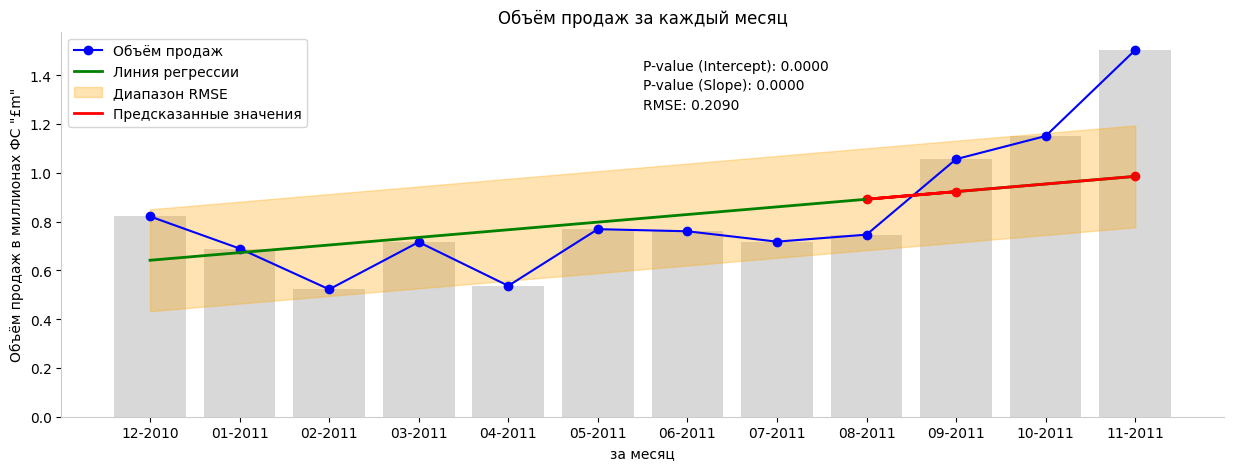

In [192]:
plot_sales(sales_grouped_filtered) # Вызов функции для основного отображения датасета
plot_metrics(x_values, intercept_pvalue, slope_pvalue, rmse = rmse_train) # Вызов функции визуализации метрик
plot_y_pred(y_pred_series, color='red') # Вызов функции для визуализации добавленной линии предсказаний

## Вывод по оценке тренировочных и тестовых данных регуляризированной модели линейной регрессии

Корень среднеквадратичной ошибки (RMSE) регуляризированной модели линейной регрессии:
 - обучающей выборки: 0.21
 - тестовых данных: 0.19

RMSE (0,19) тестовых данных, значительно меньше чем было (0,25). RMSE стало приемлемой в сравнении с диапазоном значений 0,5-1,5. После подбора гиперпараметров, регуляризированная модель линейной регрессии, обобщает свои знания, т.к. RMSE для тренировочных и тестовых данных отличаются не сильно. Но самое главное то, что модель не переобучена, т.к. RMSE на тренировочных данных даже выше чем на тестовых. Это означает, что модель хорошо предсказывает.

## Вывод по статистической значимости регуляризированной модели линейной регрессии

Поскольку p-значения обоих коэффициентов много меньше порога значимости α = 0,01, можно заключить, что оба коэффициента являются значимыми. Это подтверждает статистически значимую связь между месяцами и объёмами продажи, т.е. модель линейной регрессии является статистически значимой.



# Заключение по оценке и выбору модели линейной регрессии
Мы получили Ridge модель линейной регрессии, которая способна избежать переобучения, но при этом не очень хорошо обобщает свои знания на новые данные. Это типичное поведение для регрессионных методов с регуляризацией, таких как Ridge.

In [193]:
future_months = {
    'year': [2011, 2012, 2012],  # Годы 2011 и 2012
    'month': [12, 1, 2]  # Декабрь, Январь, Февраль
}
future_df = pd.DataFrame(future_months)
predictions_m = model.predict(future_df) # Передаем в модель будущие месяцы для прогнозирования объёмов продаж
future_df['sales_volume_m'] = predictions_m # Добавляем прогнозируемые объёмы продаж в future_df
future_df['month_year'] = pd.to_datetime(future_df[['month', 'year']].assign(day=1)) # Добавляем период month_year в формате datetime
future_df['month_year'] = pd.to_datetime(future_df['month_year']).dt.to_period('M') # Преобразовываем во временной период
future_df

,year,month,sales_volume_m,month_year
0,2011,12,0.985794,2011-12
1,2012,1,0.641721,2012-01
2,2012,2,0.673001,2012-02


## Прогнозирование объёмов продаж
Для стратегического планирования, спрогнозируем объём продаж на три новых месяца, с помощью регуляризированной модели линейной регрессии Ridge. Создадим датафрейм для прогнозных значений на 3 следующих месяца 2012 года.

In [194]:
future_df_copy = future_df.copy() # Создаем копию DataFrame, чтобы не изменять исходный
result_df_m_res = pd.concat([sales_grouped_filtered, future_df_copy], ignore_index=True) # объединяем оба df по месяцам
mask = (future_df_copy['year'] == 2012) # Находим строки, где year == 2012

In [195]:
future_df_copy.loc[mask, 'sales_volume_m'] += k # Увеличиваем значения sales_volume_m на коэффициент коррекции k
result_df_m = pd.concat([sales_grouped_filtered, future_df_copy], ignore_index=True) # объединяем корректные df по месяцам
result_df_m

,month,year,month_year,sales_volume_m
0,12,2010,2010-12,0.821453
1,1,2011,2011-01,0.689812
2,2,2011,2011-02,0.522546
3,3,2011,2011-03,0.716215
4,4,2011,2011-04,0.536968
5,5,2011,2011-05,0.769297
6,6,2011,2011-06,0.760547
7,7,2011,2011-07,0.718076
8,8,2011,2011-08,0.746779
9,9,2011,2011-09,1.056435


In [196]:
y_pred_series_res = pd.Series(result_df_m_res['sales_volume_m'][11:15]) # Перезаписываем Series предсказанных значений с учетом индексации
y_pred_series = pd.Series(result_df_m['sales_volume_m'][11:15]) # Перезаписываем Series предсказанных значений с учетом индексации
x_values = np.arange(len(result_df_m['month_year'])) # Генерация x-значений для отображения линии регрессии в диапазоне + три месяца

Продолжим график прогнозными данными, для этого объединим датафреймы. Проведём сравнение фактических данных и прогнозов модели с помощью графика. График показывает, насколько хорошо модель отражает изменение объема продаж от месяца к месяцу.

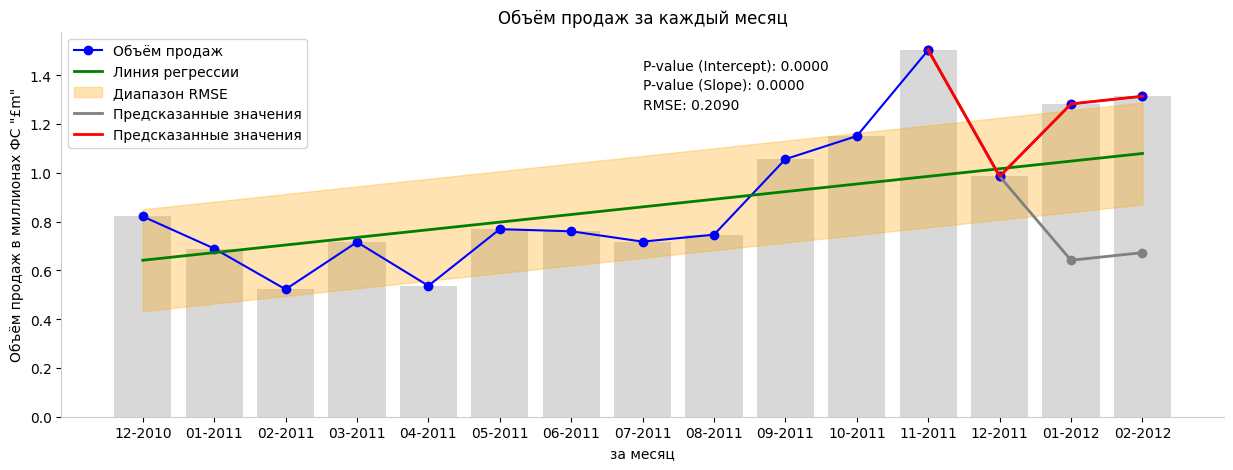

In [197]:
plot_sales(result_df_m) # Вызов функции для основного отображения
plot_metrics(x_values, intercept_pvalue, slope_pvalue, rmse = rmse_train) # Вызов функции визуализации метрик
plot_y_pred(y_pred_series_res, color='grey') # Вызов функции для визуализации линии предсказаний без коррекции y_pred_series_res
plot_y_pred(y_pred_series, color='red') # Вызов функции для визуализации линии откорректированных предсказаний y_pred_series

## Вывод по оценке качества регуляризированной модели линейной регрессии

Прогнозируемое значение декабря 2011 года ниже ноября 2011 - это логично. Такое снижение подтверждается на еженедельной визуализации снижением продаж с каждой последующей из 4-х недель декабря 2011.

Предсказания на январь и февраль 2012 года не показали сезонное снижение продаж по отношению к февралю 2011 года. Но продемонстрировали тенденцию к увеличению согласно коэффициенту наклона линейной регрессии.

При интерпретации результатов, важно не только оценивать статистическую значимость модели, но и интерпретировать коэффициенты. Например, коэффициент наклона предполагает, насколько изменится объем продаж при увеличении месяца на единицу.

В нашем случае, наклон примерно 30 000 фунтов стерлингов в месяц. Это означает, что минимум следующего года, с высокой долей вероятности будет выше минимума предыдущего года на 360 000.

Можно отметить, правильную работу коэффициента коррекции. Например, если продолжить линию регрессии от минимума 2011 года, то прогнозируемое минимальное значение января 2012 года, (без коррекции) будет находиться значительно ниже этой линии. Это означает расхождение с показателем наклона линейной регрессии. В свою очередь именно коррекция не даёт повторить сезонное снижение продаж в январе и феврале 2012 года по аналогии с 2011 годом.

#Заключение по прогнозу регуляризированной модели линейной регрессии
Модель ленейной регрессии хорошо отрабатывает сезонный фактор прогноза объёмов продажна на перспективу 1-го месяца. К увеличению прогнозного диапазона необходимо подходить очень аккуратно.

В целом модель хорошо справилась с задачей общей оценки текущих объёмов продаж британского сетевого интернет-магазина розничной торговли и прогнозированием продаж на следующие три месяца.

# Рекомендации стейкхолдерам для стратегического планирования на начало 2012 года

**Генеральному директору**

Учитывая падение прогнозируемых значений, рассмотрите возможность пересмотра бизнес-стратегий, чтобы адаптироваться к потенциальному снижению спроса.
Инвестируйте в развитие новых продуктов или услуг, которые могут привлечь клиентов в условиях неопределенности.

**Директору по маркетингу**

Сосредоточьтесь на анализе целевой аудитории и изменениях в потребительских предпочтениях, чтобы адаптировать рекламные сообщения.
Увеличьте акцент на цифровом маркетинге, который может быть более эффективным в условиях снижения традиционных продаж.

**Финансовый директор**

Обратите внимание на снижение прогнозов и пересмотрите бюджетные планы, учитывая возможное уменьшение доходов в начале 2012 года.
Рассмотрите возможность создания резервного фонда для поддержки бизнеса в случае ухудшения ситуации.

**Руководитель складской логистики**

Проанализируйте текущие уровни запасов и предсказываемое снижение спроса, чтобы избежать избыточных запасов.
Установите более гибкие запасы, позволяя быстро реагировать на изменения в продажах и спросе, что поможет минимизировать потери.